# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Sanity Functions

In [2]:
def sanity_check(model, use_softplus=False, transformation_grad=1):

    model_dict = dict(model.state_dict())
    print(model_dict.keys())

    if not use_softplus:
        a = model.transformation.params[transformation_grad].detach().cpu()
        eps = torch.empty_like(a)
        eps[0] = a[0]
        eps[1:] = torch.nn.functional.softplus(a[1:])
        eps = torch.cumsum(eps, dim=0)
    
    is_mono = torch.all(torch.diff(eps) > 0)
    print(is_mono.item())
        
    print(f"{eps}")  # should be strictly increasing
    plt.plot(range(len(eps)), eps, marker='o')
    plt.title("Monotonic spline coefficients ε_j,p")
    plt.xlabel("Basis index p")
    plt.ylabel("ε_j,p")
    plt.show()

def series(x):
    """Return a 1D numpy array from tensor OR list/tuple of (tensors|floats)."""
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    if isinstance(x, (list, tuple)):
        return np.array([t.detach().cpu().item() if torch.is_tensor(t) else float(t) for t in x])
    return np.asarray(x)

# Test 1 ndependence copula + standard Gaussian marginals (N(0,1))

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Independent Copula and add Gaussian marginals.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [3]:
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)


# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [4]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/tmp/ipykernel_951286/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_951286/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_951286/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [5]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.indep)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [6]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [7]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_test)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_test)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [8]:
model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 3/1000 [00:00<00:46, 21.27it/s]

current_loss: tensor(1.4623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4326, grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:00<00:35, 28.07it/s]

current_loss: tensor(1.4315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4312, grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:00<00:34, 28.73it/s]

current_loss: tensor(1.4311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4309, grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:00<00:42, 23.04it/s]

current_loss: tensor(1.4309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:01<00:34, 28.03it/s]

current_loss: tensor(1.4305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:01<00:29, 32.68it/s]

current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:01<00:28, 34.24it/s]

current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:01<00:29, 31.89it/s]

current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)


  5%|▌         | 53/1000 [00:01<00:28, 33.12it/s]

current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:02<00:32, 28.80it/s]

current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:02<00:29, 31.28it/s]

current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)


  7%|▋         | 74/1000 [00:02<00:27, 33.72it/s]

current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, grad_fn=<MeanBackward0>)


  8%|▊         | 78/1000 [00:02<00:30, 30.56it/s]

current_loss: tensor(1.4302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4301, grad_fn=<MeanBackward0>)


  9%|▊         | 87/1000 [00:02<00:26, 34.22it/s]

current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)


 10%|▉         | 96/1000 [00:03<00:24, 36.95it/s]

current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)


 10%|█         | 104/1000 [00:03<00:26, 33.41it/s]

current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)


 11%|█         | 108/1000 [00:03<00:29, 30.47it/s]

current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)


 12%|█▏        | 117/1000 [00:03<00:26, 33.46it/s]

current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)


 12%|█▏        | 121/1000 [00:03<00:28, 31.17it/s]

current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)


 12%|█▎        | 125/1000 [00:04<00:26, 32.49it/s]

current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300,

 13%|█▎        | 129/1000 [00:04<00:45, 18.96it/s]

current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300,

 13%|█▎        | 130/1000 [00:04<00:31, 27.81it/s]

current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4300, grad_fn=<MeanBackward0>)
Early Stop at iteration 130 with minimal loss tensor(1.4300, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    "RW2": { "tau_a": 1.1, "tau_b": 10 },  #E[λ_T] = sehr groß  (smooth but not stiff)
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


D = 24
First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 1/200 [00:00<01:38,  2.02it/s]

ELPD change after μ-nudge: -17.406982421875
[1/200] train=40.8948  val_ELPD=-1.4456  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0510 σmin=0.0510 σmax=0.0510   tau4=0.1995497703 rank=20  E_qf≈0.0896  tau*E[qf]≈0.01787  Δ=+8.95e-02


  1%|          | 2/200 [00:00<01:06,  2.99it/s]

ELPD change after μ-nudge: -13.353271484375
[2/200] train=39.8257  val_ELPD=-1.4450  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0520 σmin=0.0520 σmax=0.0520   tau4=0.280144564 rank=20  E_qf≈0.0896  tau*E[qf]≈0.02509  Δ=+8.06e-02


  2%|▏         | 3/200 [00:00<00:55,  3.54it/s]

ELPD change after μ-nudge: -10.80224609375
[3/200] train=40.9038  val_ELPD=-1.4442  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0530 σmin=0.0530 σmax=0.0530   tau4=0.3526798784 rank=20  E_qf≈0.0896  tau*E[qf]≈0.03158  Δ=+7.25e-02


  2%|▏         | 4/200 [00:01<00:50,  3.88it/s]

ELPD change after μ-nudge: -7.809326171875
[4/200] train=34.2230  val_ELPD=-1.4435  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0541 σmin=0.0541 σmax=0.0541   tau4=0.4179616614 rank=20  E_qf≈0.0896  tau*E[qf]≈0.03743  Δ=+6.53e-02


  2%|▎         | 5/200 [00:01<00:47,  4.09it/s]

ELPD change after μ-nudge: -4.948486328125
[5/200] train=39.1490  val_ELPD=-1.4430  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0551 σmin=0.0551 σmax=0.0551   tau4=0.476715266 rank=20  E_qf≈0.0896  tau*E[qf]≈0.04269  Δ=+5.88e-02


  3%|▎         | 6/200 [00:01<00:45,  4.24it/s]

ELPD change after μ-nudge: -2.972412109375
[6/200] train=34.9873  val_ELPD=-1.4423  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0562 σmin=0.0562 σmax=0.0562   tau4=0.5295935102 rank=20  E_qf≈0.0896  tau*E[qf]≈0.04743  Δ=+5.29e-02


  4%|▎         | 7/200 [00:01<00:45,  4.23it/s]

ELPD change after μ-nudge: -1.35693359375
[7/200] train=37.2841  val_ELPD=-1.4418  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0573 σmin=0.0573 σmax=0.0573   tau4=0.57718393 rank=20  E_qf≈0.0896  tau*E[qf]≈0.05169  Δ=+4.76e-02


  4%|▍         | 8/200 [00:02<00:45,  4.20it/s]

ELPD change after μ-nudge: -2.03662109375
[8/200] train=36.0385  val_ELPD=-1.4406  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0584 σmin=0.0584 σmax=0.0584   tau4=0.6200153078 rank=20  E_qf≈0.0896  tau*E[qf]≈0.05552  Δ=+4.28e-02


  4%|▍         | 9/200 [00:02<00:44,  4.27it/s]

ELPD change after μ-nudge: -4.192626953125
[9/200] train=34.4682  val_ELPD=-1.4391  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0596 σmin=0.0596 σmax=0.0596   tau4=0.6585635478 rank=20  E_qf≈0.0896  tau*E[qf]≈0.05898  Δ=+3.85e-02


  5%|▌         | 10/200 [00:02<00:43,  4.35it/s]

ELPD change after μ-nudge: -6.65966796875
[10/200] train=34.9373  val_ELPD=-1.4375  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0607 σmin=0.0607 σmax=0.0607   tau4=0.6932569638 rank=20  E_qf≈0.0896  tau*E[qf]≈0.06208  Δ=+3.47e-02


  6%|▌         | 11/200 [00:02<00:46,  4.07it/s]

ELPD change after μ-nudge: -8.05712890625
[11/200] train=33.1431  val_ELPD=-1.4361  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0619 σmin=0.0619 σmax=0.0619   tau4=0.7244810382 rank=20  E_qf≈0.0896  tau*E[qf]≈0.06488  Δ=+3.12e-02


  6%|▌         | 12/200 [00:03<00:48,  3.91it/s]

ELPD change after μ-nudge: -8.749755859375
[12/200] train=35.8941  val_ELPD=-1.4349  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0631 σmin=0.0631 σmax=0.0631   tau4=0.7525827052 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0674  Δ=+2.81e-02


  6%|▋         | 13/200 [00:03<00:49,  3.80it/s]

ELPD change after μ-nudge: -8.571044921875
[13/200] train=34.3890  val_ELPD=-1.4338  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0644 σmin=0.0644 σmax=0.0644   tau4=0.7778742055 rank=20  E_qf≈0.0896  tau*E[qf]≈0.06966  Δ=+2.53e-02


  7%|▋         | 14/200 [00:03<00:49,  3.73it/s]

ELPD change after μ-nudge: -7.614501953125
[14/200] train=34.2794  val_ELPD=-1.4329  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0656 σmin=0.0656 σmax=0.0656   tau4=0.8006365557 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0717  Δ=+2.28e-02


  8%|▊         | 15/200 [00:03<00:50,  3.67it/s]

ELPD change after μ-nudge: -8.218505859375
[15/200] train=31.8577  val_ELPD=-1.4320  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0669 σmin=0.0669 σmax=0.0669   tau4=0.8211226709 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07353  Δ=+2.05e-02


  8%|▊         | 16/200 [00:04<00:50,  3.64it/s]

ELPD change after μ-nudge: -9.23486328125
[16/200] train=31.0251  val_ELPD=-1.4310  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0682 σmin=0.0682 σmax=0.0682   tau4=0.8395601746 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07519  Δ=+1.84e-02


  8%|▊         | 17/200 [00:04<00:50,  3.62it/s]

ELPD change after μ-nudge: -9.75927734375
[17/200] train=33.5094  val_ELPD=-1.4301  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0695 σmin=0.0695 σmax=0.0695   tau4=0.856153928 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07667  Δ=+1.66e-02


  9%|▉         | 18/200 [00:04<00:50,  3.61it/s]

ELPD change after μ-nudge: -10.005859375
[18/200] train=31.1599  val_ELPD=-1.4293  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0709 σmin=0.0709 σmax=0.0709   tau4=0.871088306 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07801  Δ=+1.49e-02


 10%|▉         | 19/200 [00:05<00:50,  3.61it/s]

ELPD change after μ-nudge: -9.47216796875
[19/200] train=30.8072  val_ELPD=-1.4286  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0723 σmin=0.0723 σmax=0.0723   tau4=0.8845292462 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07921  Δ=+1.34e-02


 10%|█         | 20/200 [00:05<00:50,  3.59it/s]

ELPD change after μ-nudge: -8.433837890625
[20/200] train=30.6410  val_ELPD=-1.4279  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0737 σmin=0.0737 σmax=0.0737   tau4=0.8966260923 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0803  Δ=+1.21e-02


 10%|█         | 21/200 [00:05<00:56,  3.18it/s]

ELPD change after μ-nudge: -7.352294921875
[21/200] train=30.3580  val_ELPD=-1.4273  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0751 σmin=0.0751 σmax=0.0751   tau4=0.9075132539 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08127  Δ=+1.09e-02


 11%|█         | 22/200 [00:06<01:00,  2.95it/s]

ELPD change after μ-nudge: -6.030029296875
[22/200] train=29.6020  val_ELPD=-1.4267  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0766 σmin=0.0766 σmax=0.0766   tau4=0.9173116993 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08215  Δ=+9.80e-03


 12%|█▏        | 23/200 [00:06<01:03,  2.80it/s]

ELPD change after μ-nudge: -4.967529296875
[23/200] train=27.9725  val_ELPD=-1.4262  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0781 σmin=0.0781 σmax=0.0781   tau4=0.9261303002 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08294  Δ=+8.82e-03


 12%|█▏        | 24/200 [00:06<01:04,  2.71it/s]

ELPD change after μ-nudge: -4.200927734375
[24/200] train=29.7344  val_ELPD=-1.4256  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0796 σmin=0.0796 σmax=0.0796   tau4=0.9340670409 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08365  Δ=+7.94e-03


 12%|█▎        | 25/200 [00:07<01:06,  2.65it/s]

ELPD change after μ-nudge: -3.524658203125
[25/200] train=28.5096  val_ELPD=-1.4251  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0811 σmin=0.0811 σmax=0.0811   tau4=0.9412101076 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08429  Δ=+7.14e-03


 13%|█▎        | 26/200 [00:07<01:06,  2.60it/s]

ELPD change after μ-nudge: -4.275634765625
[26/200] train=27.1684  val_ELPD=-1.4243  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0827 σmin=0.0827 σmax=0.0827   tau4=0.9476388677 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08486  Δ=+6.43e-03


 14%|█▎        | 27/200 [00:08<01:07,  2.57it/s]

ELPD change after μ-nudge: -5.177490234375
[27/200] train=28.2386  val_ELPD=-1.4236  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0843 σmin=0.0843 σmax=0.0843   tau4=0.9534247517 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08538  Δ=+5.79e-03


 14%|█▍        | 28/200 [00:08<01:07,  2.55it/s]

ELPD change after μ-nudge: -6.458740234375
[28/200] train=27.4165  val_ELPD=-1.4229  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0859 σmin=0.0859 σmax=0.0859   tau4=0.9586320473 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08585  Δ=+5.21e-03


 14%|█▍        | 29/200 [00:08<01:07,  2.54it/s]

ELPD change after μ-nudge: -7.799560546875
[29/200] train=26.3578  val_ELPD=-1.4223  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0875 σmin=0.0875 σmax=0.0876   tau4=0.9633186134 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08627  Δ=+4.69e-03


 15%|█▌        | 30/200 [00:09<01:07,  2.53it/s]

ELPD change after μ-nudge: -9.267578125
[30/200] train=25.6297  val_ELPD=-1.4216  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0892 σmin=0.0892 σmax=0.0892   tau4=0.9675365228 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08665  Δ=+4.22e-03


 16%|█▌        | 31/200 [00:09<01:19,  2.14it/s]

ELPD change after μ-nudge: -9.951171875
[31/200] train=24.9855  val_ELPD=-1.4210  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0909 σmin=0.0909 σmax=0.0910   tau4=0.9713326413 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08699  Δ=+3.80e-03


 16%|█▌        | 32/200 [00:10<01:27,  1.92it/s]

ELPD change after μ-nudge: -10.12890625
[32/200] train=24.8744  val_ELPD=-1.4206  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0927 σmin=0.0927 σmax=0.0927   tau4=0.974749148 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08729  Δ=+3.42e-03


 16%|█▋        | 33/200 [00:11<01:32,  1.80it/s]

ELPD change after μ-nudge: -10.42578125
[33/200] train=24.1368  val_ELPD=-1.4202  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0945 σmin=0.0945 σmax=0.0945   tau4=0.977824004 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08757  Δ=+3.07e-03


 17%|█▋        | 34/200 [00:11<01:36,  1.72it/s]

ELPD change after μ-nudge: -10.363525390625
[34/200] train=24.2594  val_ELPD=-1.4199  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0963 σmin=0.0963 σmax=0.0963   tau4=0.9805913744 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08782  Δ=+2.77e-03


 18%|█▊        | 35/200 [00:12<01:38,  1.67it/s]

ELPD change after μ-nudge: -10.01904296875
[35/200] train=24.0819  val_ELPD=-1.4196  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0981 σmin=0.0981 σmax=0.0981   tau4=0.9830820077 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08804  Δ=+2.49e-03


 18%|█▊        | 36/200 [00:13<01:40,  1.64it/s]

ELPD change after μ-nudge: -9.02197265625
[36/200] train=23.1946  val_ELPD=-1.4194  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1000 σmin=0.1000 σmax=0.1000   tau4=0.9853235778 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08824  Δ=+2.24e-03


 18%|█▊        | 37/200 [00:13<01:41,  1.61it/s]

ELPD change after μ-nudge: -7.734619140625
[37/200] train=22.3982  val_ELPD=-1.4191  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1019 σmin=0.1019 σmax=0.1019   tau4=0.9873409908 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08842  Δ=+2.02e-03


 19%|█▉        | 38/200 [00:14<01:41,  1.60it/s]

ELPD change after μ-nudge: -6.1328125
[38/200] train=22.1347  val_ELPD=-1.4188  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1038 σmin=0.1038 σmax=0.1038   tau4=0.9891566625 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08858  Δ=+1.82e-03


 20%|█▉        | 39/200 [00:15<01:41,  1.58it/s]

ELPD change after μ-nudge: -4.611572265625
[39/200] train=22.0416  val_ELPD=-1.4185  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1058 σmin=0.1058 σmax=0.1058   tau4=0.990790767 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08873  Δ=+1.63e-03


 20%|██        | 40/200 [00:15<01:41,  1.58it/s]

ELPD change after μ-nudge: -2.984619140625
[40/200] train=21.5382  val_ELPD=-1.4183  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1078 σmin=0.1078 σmax=0.1078   tau4=0.9922614611 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08886  Δ=+1.47e-03


 20%|██        | 41/200 [00:16<02:04,  1.28it/s]

ELPD change after μ-nudge: -1.903076171875
[41/200] train=21.0240  val_ELPD=-1.4181  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1099 σmin=0.1098 σmax=0.1099   tau4=0.9935850858 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08898  Δ=+1.32e-03


 21%|██        | 42/200 [00:17<02:19,  1.13it/s]

ELPD change after μ-nudge: -1.062255859375
[42/200] train=20.7833  val_ELPD=-1.4179  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1119 σmin=0.1119 σmax=0.1120   tau4=0.994776348 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08909  Δ=+1.19e-03


 22%|██▏       | 43/200 [00:19<02:30,  1.04it/s]

ELPD change after μ-nudge: -0.9765625
[43/200] train=20.1492  val_ELPD=-1.4176  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1141 σmin=0.1140 σmax=0.1141   tau4=0.995848484 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08918  Δ=+1.07e-03


 22%|██▏       | 44/200 [00:20<02:37,  1.01s/it]

ELPD change after μ-nudge: -0.88671875
[44/200] train=19.8106  val_ELPD=-1.4175  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1162 σmin=0.1162 σmax=0.1162   tau4=0.9968134064 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08927  Δ=+9.65e-04


 22%|██▎       | 45/200 [00:21<02:42,  1.05s/it]

ELPD change after μ-nudge: -1.466552734375
[45/200] train=18.9855  val_ELPD=-1.4174  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1184 σmin=0.1184 σmax=0.1184   tau4=0.9976818366 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08935  Δ=+8.68e-04


 23%|██▎       | 46/200 [00:22<02:44,  1.07s/it]

ELPD change after μ-nudge: -2.8408203125
[46/200] train=19.0936  val_ELPD=-1.4175  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1206 σmin=0.1206 σmax=0.1206   tau4=0.9984634237 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08942  Δ=+7.82e-04


 24%|██▎       | 47/200 [00:23<02:46,  1.09s/it]

ELPD change after μ-nudge: -4.364990234375
[47/200] train=17.7370  val_ELPD=-1.4178  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1229 σmin=0.1229 σmax=0.1229   tau4=0.9991668521 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08948  Δ=+7.03e-04


 24%|██▍       | 48/200 [00:24<02:47,  1.10s/it]

ELPD change after μ-nudge: -5.82421875
[48/200] train=18.4373  val_ELPD=-1.4185  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1252 σmin=0.1252 σmax=0.1252   tau4=0.9997999377 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08954  Δ=+6.33e-04


 24%|██▍       | 49/200 [00:25<02:47,  1.11s/it]

ELPD change after μ-nudge: -7.0791015625
[49/200] train=17.3455  val_ELPD=-1.4193  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1275 σmin=0.1275 σmax=0.1276   tau4=1.000369715 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08959  Δ=+5.70e-04


 25%|██▌       | 50/200 [00:26<02:47,  1.12s/it]

ELPD change after μ-nudge: -7.93212890625
[50/200] train=16.9852  val_ELPD=-1.4197  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1299 σmin=0.1299 σmax=0.1300   tau4=1.000882514 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08963  Δ=+5.13e-04


 26%|██▌       | 51/200 [00:28<02:46,  1.12s/it]

ELPD change after μ-nudge: -7.44677734375
[51/200] train=16.5550  val_ELPD=-1.4196  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.1323 σmin=0.1323 σmax=0.1324   tau4=1.001344033 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08967  Δ=+4.62e-04


 26%|██▌       | 52/200 [00:29<02:46,  1.12s/it]

ELPD change after μ-nudge: -7.28564453125
[52/200] train=16.1003  val_ELPD=-1.4194  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.1336 σmin=0.1335 σmax=0.1336   tau4=1.001759401 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08971  Δ=+4.15e-04


 26%|██▋       | 53/200 [00:30<02:45,  1.12s/it]

ELPD change after μ-nudge: -6.734130859375
[53/200] train=15.4285  val_ELPD=-1.4192  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.1348 σmin=0.1347 σmax=0.1348   tau4=1.002133232 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08974  Δ=+3.74e-04


 27%|██▋       | 54/200 [00:31<02:44,  1.12s/it]

ELPD change after μ-nudge: -5.972412109375
[54/200] train=15.4478  val_ELPD=-1.4187  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.1361 σmin=0.1360 σmax=0.1361   tau4=1.002469679 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08977  Δ=+3.36e-04


 28%|██▊       | 55/200 [00:32<02:43,  1.13s/it]

ELPD change after μ-nudge: -5.4169921875
[55/200] train=15.9549  val_ELPD=-1.4183  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.1373 σmin=0.1372 σmax=0.1373   tau4=1.002772482 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0898  Δ=+3.03e-04


 28%|██▊       | 56/200 [00:33<02:42,  1.13s/it]

ELPD change after μ-nudge: -4.886474609375
[56/200] train=15.0842  val_ELPD=-1.4178  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.1386 σmin=0.1385 σmax=0.1386   tau4=1.003045005 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08983  Δ=+2.73e-04


 28%|██▊       | 57/200 [00:34<02:41,  1.13s/it]

ELPD change after μ-nudge: -4.421630859375
[57/200] train=15.3810  val_ELPD=-1.4174  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.1399 σmin=0.1398 σmax=0.1399   tau4=1.003290275 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08985  Δ=+2.45e-04


 28%|██▊       | 57/200 [00:36<01:30,  1.58it/s]

ELPD change after μ-nudge: -3.491455078125
[58/200] train=14.3944  val_ELPD=-1.4170  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.1411 σmin=0.1411 σmax=0.1412   tau4=1.003511018 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08987  Δ=+2.21e-04
Early stop @ epoch 58: no val improvement for 15 epochs.


In [10]:
print(model_freq.transformation.params[0])
print(model.transformation.params[0])

print(len(model_freq.transformation.params[0]))
print(len(model.transformation.params[0]))


print(model_freq.transformation.params[1])
print(model.transformation.params[1])

print(len(model_freq.transformation.params[1]))
print(len(model.transformation.params[1]))

Parameter containing:
tensor([-10.4113,   1.3038,   1.3038,   1.3038,   2.2215,   2.2538,   2.0426,
          2.1179,   1.3629,   1.6508,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-10.0632,   1.5731,   1.5738,   1.5741,   1.5785,   1.7518,   1.9887,
          2.0004,   1.9739,   1.9955,   1.6411,   1.6411], device='cuda:0',
       requires_grad=True)
12
12
Parameter containing:
tensor([-10.7163,   1.0614,   1.0614,   1.0614,   3.4067,   1.9306,   2.1133,
          2.0183,   1.8736,   1.6411,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-10.0517,   1.5847,   1.5848,   1.5846,   1.5920,   1.7489,   1.9813,
          1.9999,   1.9933,   1.6411,   1.6411,   1.6411], device='cuda:0',
       requires_grad=True)
12
12


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.4113,  -8.8672,  -7.3232,  -5.7792,  -3.4547,  -1.1011,   1.0634,
          3.2949,   4.8857,   6.7120,   8.5302,  10.3484])


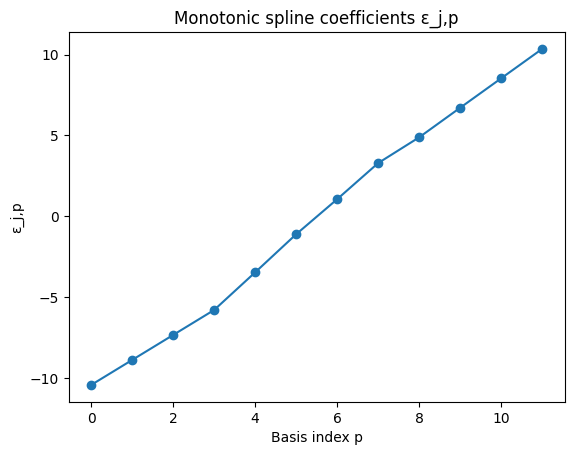

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0632,  -8.3016,  -6.5394,  -4.7770,  -3.0110,  -1.0992,   1.0178,
          3.1451,   5.2490,   7.3720,   9.1901,  11.0083])


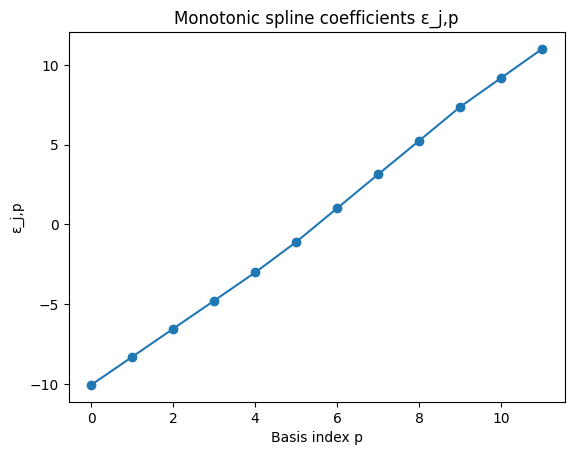

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.7163,  -9.3579,  -7.9994,  -6.6409,  -3.2016,  -1.1356,   1.0918,
          3.2348,   5.2512,   7.0694,   8.8876,  10.7058])


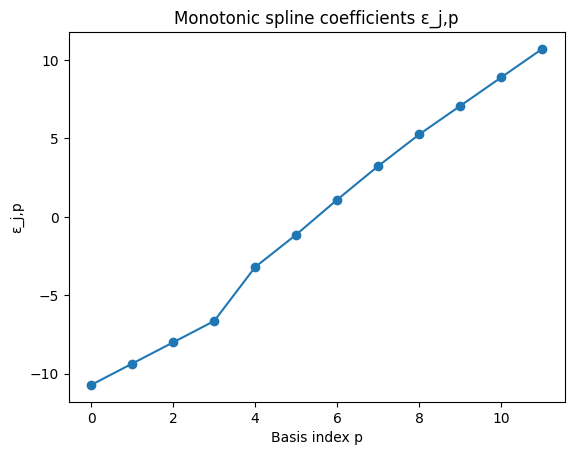

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0517,  -8.2805,  -6.5093,  -4.7382,  -2.9610,  -1.0517,   1.0588,
          3.1856,   5.3066,   7.1248,   8.9430,  10.7612])


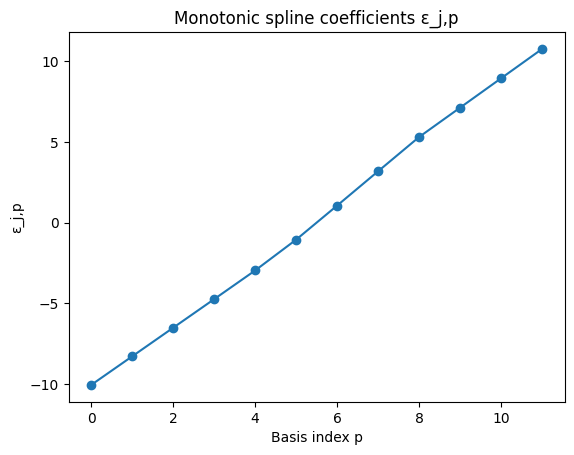

In [11]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

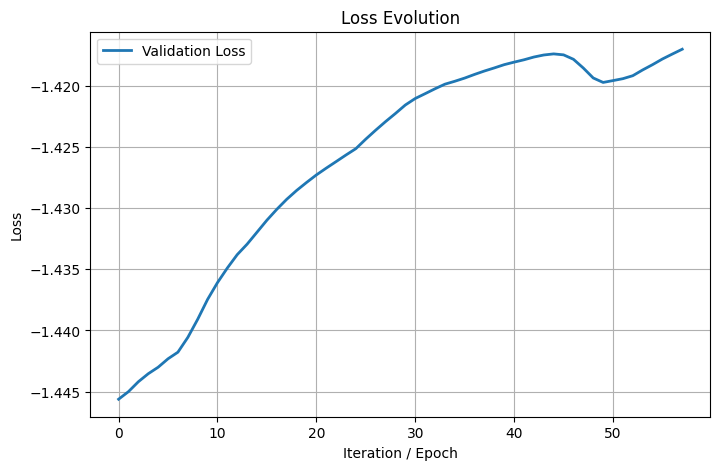

In [12]:
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
#output.keys()

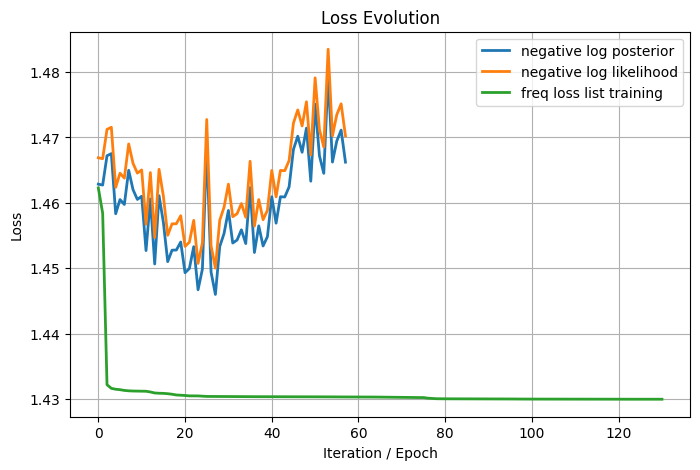

tensor(1.4300, grad_fn=<AddBackward0>)
1.4500315189361572


In [14]:
elbo_loss = output['loss_history']
neg_log_posterior = output["neg_log_posterior_bgtm"]
neg_log_likelihood = output['negative_log_likelihood']
negative_log_prior_decorrelation = output['negative_log_prior_decorrelation']
negative_log_prior_transformation = output['negative_log_prior_transformation']

neg_log_posterior_np = [t.detach().cpu().item() if torch.is_tensor(t) else t for t in neg_log_posterior]
neg_log_likelihood_np = [t.detach().cpu().item() if torch.is_tensor(t) else t for t in neg_log_likelihood]
negative_log_prior_decorrelation_np = [t.detach().cpu().item() if torch.is_tensor(t) else t for t in negative_log_prior_decorrelation]


##### FREQ #####

loss_list_training = output_freq["loss_list_training"]

# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(series(elbo_loss), label="elbo_loss", linewidth=2 )
plt.plot(series(neg_log_posterior), label="negative log posterior", linewidth=2)
plt.plot(series(neg_log_likelihood), label="negative log likelihood", linewidth=2)
#plt.plot(series(negative_log_prior_decorrelation), label="negative log prior decorrelation", linewidth=2) 
#plt.plot(series(negative_log_prior_transformation), label="negative log prior transformation", linewidth=2)

plt.plot(loss_list_training, label= "freq loss list training", linewidth=2 )

plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

print(output_freq['loss_with_penalties'])
print(min(neg_log_likelihood))

In [15]:
print(
    "freq_model nr. parameters", sum(p.numel() for p in model_freq.parameters() if p.requires_grad),
    "bay_model nr. parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))

print("VI Model params = ",output['mu'])
print("BGTM params = ",[p for p in model.parameters() if p.requires_grad])
print("GTMp params = ",[p for p in model_freq.parameters() if p.requires_grad])

freq_model nr. parameters 24 bay_model nr. parameters 24
VI Model params =  tensor([-10.0632,   1.5731,   1.5738,   1.5741,   1.5785,   1.7518,   1.9887,
          2.0004,   1.9739,   1.9955,   1.6411,   1.6411, -10.0517,   1.5847,
          1.5848,   1.5846,   1.5920,   1.7489,   1.9813,   1.9999,   1.9933,
          1.6411,   1.6411,   1.6411], device='cuda:0')
BGTM params =  [Parameter containing:
tensor([-10.0632,   1.5731,   1.5738,   1.5741,   1.5785,   1.7518,   1.9887,
          2.0004,   1.9739,   1.9955,   1.6411,   1.6411], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([-10.0517,   1.5847,   1.5848,   1.5846,   1.5920,   1.7489,   1.9813,
          1.9999,   1.9933,   1.6411,   1.6411,   1.6411], device='cuda:0',
       requires_grad=True)]
GTMp params =  [Parameter containing:
tensor([-10.4113,   1.3038,   1.3038,   1.3038,   2.2215,   2.2538,   2.0426,
          2.1179,   1.3629,   1.6508,   1.6411,   1.6411], requires_grad=True), Parameter cont

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [16]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [17]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [18]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0077
KLD GTM      Train Data:  -0.0017
KLD Gaussian Train Data:  -0.0015
KLD Copula   Train Data:  -0.0006

KLD BGTM      Test  Data:  0.0113
KLD GTM      Test  Data:  0.0005
KLD Gaussian Test  Data:  0.0012
KLD Copula   Test  Data:  0.0017


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [19]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

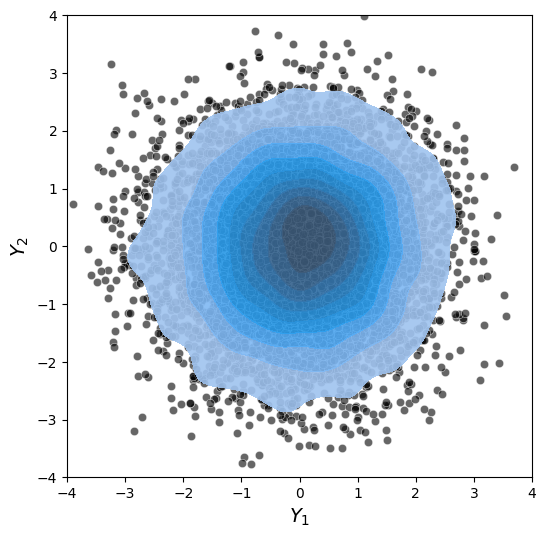

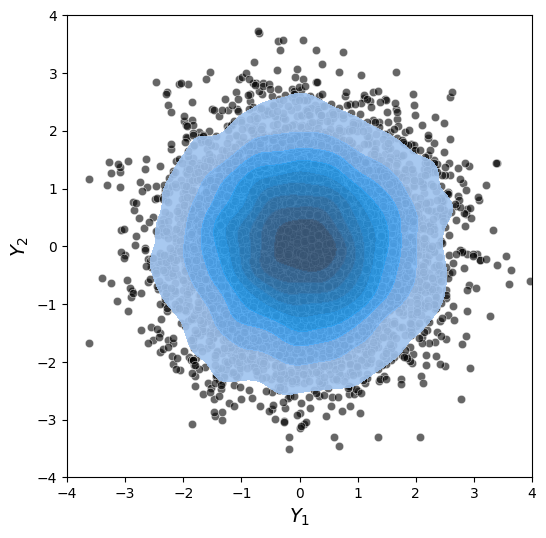

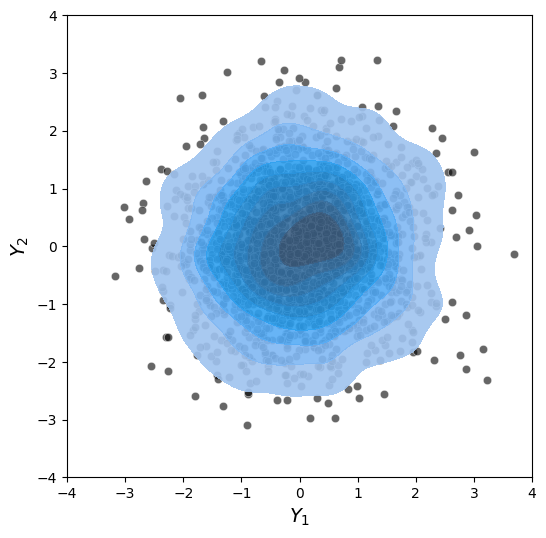

In [20]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

# Test 2
Independence copula + shifted/scaled Gaussian marginals (N(μ, σ²))

In [21]:
# User-chosen marginal parameters
mu = torch.tensor([1.5, -0.7], dtype=torch.float32)
sigma = torch.tensor([1.8, 0.6], dtype=torch.float32)  # stds

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
# Transform uniforms to shifted/scaled Gaussians
Z_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()
simulated_data_train = mu + sigma * Z_train

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
Z_val = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()
simulated_data_validate = mu + sigma * Z_val

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
Z_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()
simulated_data_test = mu + sigma * Z_test

# ---------- "True" log-likelihoods under independence + N(mu, sigma^2) ----------
loglik_true_train = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_train).sum(1)
loglik_true_validate = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_validate).sum(1)
loglik_true_test = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_test).sum(1)

# ---------- "Estimated" marginals from train (fit μ, σ from train) ----------
means = simulated_data_train.mean(0)
stds  = simulated_data_train.std(0, unbiased=True)

loglik_true_est_train = torch.distributions.Normal(means, stds).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means, stds).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means, stds).log_prob(simulated_data_test).sum(1)

In [22]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_test)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_test)

### BGTM model

In [23]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    "RW2": { "tau_a": 1.1, "tau_b": 10 },  #E[λ_T] = sehr groß  (smooth but not stiff)
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model


output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


D = 24
First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:00<00:52,  3.76it/s]

ELPD change after μ-nudge: -282.52734375
[1/200] train=41.5880  val_ELPD=-1.9523  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0510 σmin=0.0510 σmax=0.0510   tau4=0.1995497703 rank=20  E_qf≈0.0896  tau*E[qf]≈0.01787  Δ=+8.95e-02


  1%|          | 2/200 [00:00<00:47,  4.17it/s]

ELPD change after μ-nudge: -276.54638671875
[2/200] train=40.5523  val_ELPD=-1.9087  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0520 σmin=0.0520 σmax=0.0520   tau4=0.280144564 rank=20  E_qf≈0.0896  tau*E[qf]≈0.02509  Δ=+8.06e-02


  2%|▏         | 3/200 [00:00<00:45,  4.31it/s]

ELPD change after μ-nudge: -270.42578125
[3/200] train=41.5701  val_ELPD=-1.8690  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0530 σmin=0.0530 σmax=0.0530   tau4=0.3526798784 rank=20  E_qf≈0.0896  tau*E[qf]≈0.03158  Δ=+7.25e-02


  2%|▏         | 4/200 [00:00<00:44,  4.38it/s]

ELPD change after μ-nudge: -264.082763671875
[4/200] train=34.8566  val_ELPD=-1.8333  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0541 σmin=0.0541 σmax=0.0541   tau4=0.4179616614 rank=20  E_qf≈0.0896  tau*E[qf]≈0.03743  Δ=+6.53e-02


  2%|▎         | 5/200 [00:01<00:43,  4.43it/s]

ELPD change after μ-nudge: -257.521240234375
[5/200] train=39.6775  val_ELPD=-1.8017  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0551 σmin=0.0551 σmax=0.0551   tau4=0.476715266 rank=20  E_qf≈0.0896  tau*E[qf]≈0.04269  Δ=+5.88e-02


  3%|▎         | 6/200 [00:01<00:43,  4.46it/s]

ELPD change after μ-nudge: -250.75048828125
[6/200] train=35.4726  val_ELPD=-1.7740  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0562 σmin=0.0562 σmax=0.0562   tau4=0.5295935102 rank=20  E_qf≈0.0896  tau*E[qf]≈0.04743  Δ=+5.29e-02


  4%|▎         | 7/200 [00:01<00:43,  4.47it/s]

ELPD change after μ-nudge: -243.822509765625
[7/200] train=37.7955  val_ELPD=-1.7500  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0573 σmin=0.0573 σmax=0.0573   tau4=0.57718393 rank=20  E_qf≈0.0896  tau*E[qf]≈0.05169  Δ=+4.76e-02


  4%|▍         | 8/200 [00:01<00:42,  4.48it/s]

ELPD change after μ-nudge: -236.80859375
[8/200] train=36.4564  val_ELPD=-1.7297  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0584 σmin=0.0584 σmax=0.0584   tau4=0.6200153078 rank=20  E_qf≈0.0896  tau*E[qf]≈0.05552  Δ=+4.28e-02


  4%|▍         | 9/200 [00:02<00:44,  4.28it/s]

ELPD change after μ-nudge: -229.701171875
[9/200] train=34.8751  val_ELPD=-1.7130  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0596 σmin=0.0596 σmax=0.0596   tau4=0.6585635478 rank=20  E_qf≈0.0896  tau*E[qf]≈0.05898  Δ=+3.85e-02


  5%|▌         | 10/200 [00:02<00:43,  4.35it/s]

ELPD change after μ-nudge: -222.41162109375
[10/200] train=35.2944  val_ELPD=-1.6997  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0607 σmin=0.0607 σmax=0.0607   tau4=0.6932569638 rank=20  E_qf≈0.0896  tau*E[qf]≈0.06208  Δ=+3.47e-02


  6%|▌         | 11/200 [00:02<00:46,  4.08it/s]

ELPD change after μ-nudge: -214.857421875
[11/200] train=33.5205  val_ELPD=-1.6893  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0619 σmin=0.0619 σmax=0.0619   tau4=0.7244810382 rank=20  E_qf≈0.0896  tau*E[qf]≈0.06488  Δ=+3.12e-02


  6%|▌         | 12/200 [00:02<00:48,  3.89it/s]

ELPD change after μ-nudge: -207.12939453125
[12/200] train=36.2398  val_ELPD=-1.6818  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0631 σmin=0.0631 σmax=0.0632   tau4=0.7525827052 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0674  Δ=+2.81e-02


  6%|▋         | 13/200 [00:03<00:49,  3.78it/s]

ELPD change after μ-nudge: -199.1982421875
[13/200] train=34.7030  val_ELPD=-1.6765  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0644 σmin=0.0644 σmax=0.0644   tau4=0.7778742055 rank=20  E_qf≈0.0896  tau*E[qf]≈0.06966  Δ=+2.53e-02


  7%|▋         | 14/200 [00:03<00:50,  3.69it/s]

ELPD change after μ-nudge: -191.14990234375
[14/200] train=34.5948  val_ELPD=-1.6710  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0656 σmin=0.0656 σmax=0.0656   tau4=0.8006365557 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0717  Δ=+2.28e-02


  8%|▊         | 15/200 [00:03<00:50,  3.66it/s]

ELPD change after μ-nudge: -183.343994140625
[15/200] train=32.1074  val_ELPD=-1.6625  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0669 σmin=0.0669 σmax=0.0669   tau4=0.8211226709 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07353  Δ=+2.05e-02


  8%|▊         | 16/200 [00:03<00:50,  3.63it/s]

ELPD change after μ-nudge: -175.658935546875
[16/200] train=31.2750  val_ELPD=-1.6559  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0682 σmin=0.0682 σmax=0.0682   tau4=0.8395601746 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07519  Δ=+1.84e-02


  8%|▊         | 17/200 [00:04<00:50,  3.61it/s]

ELPD change after μ-nudge: -167.983642578125
[17/200] train=33.7684  val_ELPD=-1.6508  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0696 σmin=0.0695 σmax=0.0696   tau4=0.856153928 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07667  Δ=+1.66e-02


  9%|▉         | 18/200 [00:04<00:50,  3.60it/s]

ELPD change after μ-nudge: -160.42041015625
[18/200] train=31.4057  val_ELPD=-1.6471  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0709 σmin=0.0709 σmax=0.0709   tau4=0.871088306 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07801  Δ=+1.49e-02


 10%|▉         | 19/200 [00:04<00:50,  3.59it/s]

ELPD change after μ-nudge: -152.90087890625
[19/200] train=31.0699  val_ELPD=-1.6444  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0723 σmin=0.0723 σmax=0.0723   tau4=0.8845292462 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07921  Δ=+1.34e-02


 10%|█         | 20/200 [00:05<00:50,  3.58it/s]

ELPD change after μ-nudge: -145.57421875
[20/200] train=30.8720  val_ELPD=-1.6423  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0737 σmin=0.0737 σmax=0.0737   tau4=0.8966260923 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0803  Δ=+1.21e-02


 10%|█         | 21/200 [00:05<00:56,  3.18it/s]

ELPD change after μ-nudge: -138.554931640625
[21/200] train=30.5869  val_ELPD=-1.6404  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0751 σmin=0.0751 σmax=0.0751   tau4=0.9075132539 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08127  Δ=+1.09e-02


 11%|█         | 22/200 [00:05<01:00,  2.94it/s]

ELPD change after μ-nudge: -131.8564453125
[22/200] train=29.8281  val_ELPD=-1.6387  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0766 σmin=0.0766 σmax=0.0766   tau4=0.9173116993 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08215  Δ=+9.80e-03


 12%|█▏        | 23/200 [00:06<01:03,  2.80it/s]

ELPD change after μ-nudge: -125.604248046875
[23/200] train=28.1948  val_ELPD=-1.6374  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0781 σmin=0.0780 σmax=0.0781   tau4=0.9261303002 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08294  Δ=+8.82e-03


 12%|█▏        | 24/200 [00:06<01:05,  2.70it/s]

ELPD change after μ-nudge: -119.85595703125
[24/200] train=29.9465  val_ELPD=-1.6367  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0796 σmin=0.0796 σmax=0.0796   tau4=0.9340670409 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08365  Δ=+7.94e-03


 12%|█▎        | 25/200 [00:07<01:06,  2.64it/s]

ELPD change after μ-nudge: -114.6044921875
[25/200] train=28.7218  val_ELPD=-1.6348  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0811 σmin=0.0811 σmax=0.0811   tau4=0.9412101076 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08429  Δ=+7.14e-03


 13%|█▎        | 26/200 [00:07<01:07,  2.59it/s]

ELPD change after μ-nudge: -110.1357421875
[26/200] train=27.3787  val_ELPD=-1.6322  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0827 σmin=0.0827 σmax=0.0827   tau4=0.9476388677 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08486  Δ=+6.43e-03


 14%|█▎        | 27/200 [00:07<01:07,  2.57it/s]

ELPD change after μ-nudge: -106.251708984375
[27/200] train=28.4480  val_ELPD=-1.6298  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0843 σmin=0.0843 σmax=0.0843   tau4=0.9534247517 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08538  Δ=+5.79e-03


 14%|█▍        | 28/200 [00:08<01:07,  2.55it/s]

ELPD change after μ-nudge: -103.056884765625
[28/200] train=27.6248  val_ELPD=-1.6275  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0859 σmin=0.0859 σmax=0.0859   tau4=0.9586320473 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08585  Δ=+5.21e-03


 14%|█▍        | 29/200 [00:08<01:07,  2.54it/s]

ELPD change after μ-nudge: -100.5185546875
[29/200] train=26.5650  val_ELPD=-1.6255  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0876 σmin=0.0875 σmax=0.0876   tau4=0.9633186134 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08627  Δ=+4.69e-03


 15%|█▌        | 30/200 [00:09<01:07,  2.53it/s]

ELPD change after μ-nudge: -98.68408203125
[30/200] train=25.8330  val_ELPD=-1.6235  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0892 σmin=0.0892 σmax=0.0893   tau4=0.9675365228 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08665  Δ=+4.22e-03


 16%|█▌        | 31/200 [00:09<01:18,  2.15it/s]

ELPD change after μ-nudge: -97.337158203125
[31/200] train=25.1875  val_ELPD=-1.6217  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0910 σmin=0.0909 σmax=0.0910   tau4=0.9713326413 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08699  Δ=+3.80e-03


 16%|█▌        | 32/200 [00:10<01:26,  1.94it/s]

ELPD change after μ-nudge: -96.550048828125
[32/200] train=25.0754  val_ELPD=-1.6200  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0927 σmin=0.0927 σmax=0.0928   tau4=0.974749148 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08729  Δ=+3.42e-03


 16%|█▋        | 33/200 [00:10<01:32,  1.81it/s]

ELPD change after μ-nudge: -96.439697265625
[33/200] train=24.3425  val_ELPD=-1.6184  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0945 σmin=0.0945 σmax=0.0945   tau4=0.977824004 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08757  Δ=+3.07e-03


 17%|█▋        | 34/200 [00:11<01:35,  1.74it/s]

ELPD change after μ-nudge: -96.8642578125
[34/200] train=24.4584  val_ELPD=-1.6167  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0963 σmin=0.0963 σmax=0.0963   tau4=0.9805913744 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08782  Δ=+2.77e-03


 18%|█▊        | 35/200 [00:12<01:37,  1.68it/s]

ELPD change after μ-nudge: -97.827880859375
[35/200] train=24.2807  val_ELPD=-1.6151  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0981 σmin=0.0981 σmax=0.0982   tau4=0.9830820077 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08804  Δ=+2.49e-03


 18%|█▊        | 36/200 [00:12<01:39,  1.65it/s]

ELPD change after μ-nudge: -99.217041015625
[36/200] train=23.3881  val_ELPD=-1.6134  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1000 σmin=0.1000 σmax=0.1001   tau4=0.9853235778 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08824  Δ=+2.24e-03


 18%|█▊        | 37/200 [00:13<01:40,  1.63it/s]

ELPD change after μ-nudge: -101.053466796875
[37/200] train=22.5967  val_ELPD=-1.6117  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1019 σmin=0.1019 σmax=0.1020   tau4=0.9873409908 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08842  Δ=+2.02e-03


 19%|█▉        | 38/200 [00:14<01:40,  1.61it/s]

ELPD change after μ-nudge: -103.2314453125
[38/200] train=22.3293  val_ELPD=-1.6098  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1039 σmin=0.1038 σmax=0.1039   tau4=0.9891566625 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08858  Δ=+1.82e-03


 20%|█▉        | 39/200 [00:14<01:40,  1.60it/s]

ELPD change after μ-nudge: -105.7841796875
[39/200] train=22.2361  val_ELPD=-1.6079  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1058 σmin=0.1058 σmax=0.1059   tau4=0.990790767 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08873  Δ=+1.63e-03


 20%|██        | 40/200 [00:15<01:40,  1.59it/s]

ELPD change after μ-nudge: -108.60302734375
[40/200] train=21.7345  val_ELPD=-1.6058  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1078 σmin=0.1078 σmax=0.1079   tau4=0.9922614611 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08886  Δ=+1.47e-03


 20%|██        | 41/200 [00:16<02:02,  1.30it/s]

ELPD change after μ-nudge: -111.7275390625
[41/200] train=21.2141  val_ELPD=-1.6036  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1099 σmin=0.1098 σmax=0.1099   tau4=0.9935850858 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08898  Δ=+1.32e-03


 21%|██        | 42/200 [00:17<02:17,  1.15it/s]

ELPD change after μ-nudge: -115.056640625
[42/200] train=20.9714  val_ELPD=-1.6013  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1120 σmin=0.1119 σmax=0.1120   tau4=0.994776348 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08909  Δ=+1.19e-03


 22%|██▏       | 43/200 [00:18<02:28,  1.06it/s]

ELPD change after μ-nudge: -118.66015625
[43/200] train=20.3357  val_ELPD=-1.5990  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1141 σmin=0.1140 σmax=0.1142   tau4=0.995848484 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08918  Δ=+1.07e-03


 22%|██▏       | 44/200 [00:19<02:35,  1.01it/s]

ELPD change after μ-nudge: -122.302490234375
[44/200] train=19.9904  val_ELPD=-1.5967  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1162 σmin=0.1162 σmax=0.1163   tau4=0.9968134064 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08927  Δ=+9.65e-04


 22%|██▎       | 45/200 [00:20<02:39,  1.03s/it]

ELPD change after μ-nudge: -126.11865234375
[45/200] train=19.1614  val_ELPD=-1.5943  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1184 σmin=0.1184 σmax=0.1185   tau4=0.9976818366 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08935  Δ=+8.68e-04


 23%|██▎       | 46/200 [00:22<02:42,  1.05s/it]

ELPD change after μ-nudge: -130.14794921875
[46/200] train=19.2729  val_ELPD=-1.5920  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1207 σmin=0.1206 σmax=0.1207   tau4=0.9984634237 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08942  Δ=+7.82e-04


 24%|██▎       | 47/200 [00:23<02:43,  1.07s/it]

ELPD change after μ-nudge: -134.192138671875
[47/200] train=17.9104  val_ELPD=-1.5897  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1229 σmin=0.1229 σmax=0.1230   tau4=0.9991668521 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08948  Δ=+7.03e-04


 24%|██▍       | 48/200 [00:24<02:44,  1.08s/it]

ELPD change after μ-nudge: -138.204833984375
[48/200] train=18.6095  val_ELPD=-1.5875  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1252 σmin=0.1252 σmax=0.1253   tau4=0.9997999377 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08954  Δ=+6.33e-04


 24%|██▍       | 49/200 [00:25<02:44,  1.09s/it]

ELPD change after μ-nudge: -142.2021484375
[49/200] train=17.5160  val_ELPD=-1.5853  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1276 σmin=0.1275 σmax=0.1277   tau4=1.000369715 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08959  Δ=+5.70e-04


 25%|██▌       | 50/200 [00:26<02:44,  1.10s/it]

ELPD change after μ-nudge: -146.19775390625
[50/200] train=17.1603  val_ELPD=-1.5831  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1300 σmin=0.1299 σmax=0.1300   tau4=1.000882514 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08963  Δ=+5.13e-04


 26%|██▌       | 51/200 [00:27<02:44,  1.10s/it]

ELPD change after μ-nudge: -149.9013671875
[51/200] train=16.7248  val_ELPD=-1.5810  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1324 σmin=0.1323 σmax=0.1325   tau4=1.001344033 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08967  Δ=+4.62e-04


 26%|██▌       | 52/200 [00:28<02:43,  1.11s/it]

ELPD change after μ-nudge: -153.747314453125
[52/200] train=16.2695  val_ELPD=-1.5789  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1348 σmin=0.1348 σmax=0.1349   tau4=1.001759401 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08971  Δ=+4.15e-04


 26%|██▋       | 53/200 [00:29<02:42,  1.11s/it]

ELPD change after μ-nudge: -157.421875
[53/200] train=15.3747  val_ELPD=-1.5769  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1373 σmin=0.1373 σmax=0.1374   tau4=1.002133232 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08974  Δ=+3.74e-04


 27%|██▋       | 54/200 [00:30<02:41,  1.11s/it]

ELPD change after μ-nudge: -161.08154296875
[54/200] train=15.1726  val_ELPD=-1.5749  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1399 σmin=0.1398 σmax=0.1400   tau4=1.002469679 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08977  Δ=+3.36e-04


 28%|██▊       | 55/200 [00:32<02:40,  1.11s/it]

ELPD change after μ-nudge: -164.89697265625
[55/200] train=15.4599  val_ELPD=-1.5730  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1425 σmin=0.1424 σmax=0.1426   tau4=1.002772482 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0898  Δ=+3.03e-04


 28%|██▊       | 56/200 [00:33<02:39,  1.11s/it]

ELPD change after μ-nudge: -168.78857421875
[56/200] train=14.3672  val_ELPD=-1.5711  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1451 σmin=0.1450 σmax=0.1452   tau4=1.003045005 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08983  Δ=+2.73e-04


 28%|██▊       | 57/200 [00:34<02:38,  1.11s/it]

ELPD change after μ-nudge: -172.740234375
[57/200] train=14.4433  val_ELPD=-1.5693  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1478 σmin=0.1477 σmax=0.1479   tau4=1.003290275 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08985  Δ=+2.45e-04


 29%|██▉       | 58/200 [00:35<02:37,  1.11s/it]

ELPD change after μ-nudge: -176.41748046875
[58/200] train=13.2401  val_ELPD=-1.5675  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1505 σmin=0.1504 σmax=0.1506   tau4=1.003511018 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08987  Δ=+2.21e-04


 30%|██▉       | 59/200 [00:36<02:36,  1.11s/it]

ELPD change after μ-nudge: -179.84814453125
[59/200] train=13.2841  val_ELPD=-1.5658  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1533 σmin=0.1531 σmax=0.1534   tau4=1.003709687 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08989  Δ=+1.99e-04


 30%|███       | 60/200 [00:37<02:35,  1.11s/it]

ELPD change after μ-nudge: -183.5517578125
[60/200] train=13.0505  val_ELPD=-1.5641  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1561 σmin=0.1559 σmax=0.1562   tau4=1.003888489 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0899  Δ=+1.79e-04


 30%|███       | 61/200 [00:38<02:34,  1.11s/it]

ELPD change after μ-nudge: -187.6552734375
[61/200] train=12.3447  val_ELPD=-1.5624  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1589 σmin=0.1588 σmax=0.1590   tau4=1.004049411 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08992  Δ=+1.61e-04


 31%|███       | 62/200 [00:39<02:33,  1.11s/it]

ELPD change after μ-nudge: -191.93701171875
[62/200] train=12.4660  val_ELPD=-1.5607  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1618 σmin=0.1617 σmax=0.1619   tau4=1.004194241 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08993  Δ=+1.45e-04


 32%|███▏      | 63/200 [00:41<02:32,  1.11s/it]

ELPD change after μ-nudge: -196.146484375
[63/200] train=11.4979  val_ELPD=-1.5591  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1648 σmin=0.1646 σmax=0.1649   tau4=1.004324588 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08994  Δ=+1.30e-04


 32%|███▏      | 64/200 [00:42<02:35,  1.15s/it]

ELPD change after μ-nudge: -200.2626953125
[64/200] train=10.5188  val_ELPD=-1.5575  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1678 σmin=0.1676 σmax=0.1679   tau4=1.0044419 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08995  Δ=+1.17e-04


 32%|███▎      | 65/200 [00:43<02:41,  1.20s/it]

ELPD change after μ-nudge: -204.503662109375
[65/200] train=10.1875  val_ELPD=-1.5559  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1708 σmin=0.1706 σmax=0.1709   tau4=1.00454748 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08996  Δ=+1.06e-04


 33%|███▎      | 66/200 [00:44<02:36,  1.17s/it]

ELPD change after μ-nudge: -208.71240234375
[66/200] train=10.4737  val_ELPD=-1.5543  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1739 σmin=0.1737 σmax=0.1740   tau4=1.004642503 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08997  Δ=+9.50e-05


 34%|███▎      | 67/200 [00:45<02:33,  1.15s/it]

ELPD change after μ-nudge: -212.947509765625
[67/200] train=9.8558  val_ELPD=-1.5527  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1770 σmin=0.1768 σmax=0.1772   tau4=1.004728024 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08998  Δ=+8.55e-05


 34%|███▍      | 68/200 [00:46<02:30,  1.14s/it]

ELPD change after μ-nudge: -217.19580078125
[68/200] train=8.7267  val_ELPD=-1.5511  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1802 σmin=0.1800 σmax=0.1803   tau4=1.004804992 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08998  Δ=+7.70e-05


 34%|███▍      | 69/200 [00:47<02:28,  1.13s/it]

ELPD change after μ-nudge: -221.05859375
[69/200] train=9.5042  val_ELPD=-1.5495  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1835 σmin=0.1833 σmax=0.1836   tau4=1.004874264 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08999  Δ=+6.93e-05


 35%|███▌      | 70/200 [00:49<02:26,  1.13s/it]

ELPD change after μ-nudge: -225.633544921875
[70/200] train=8.1514  val_ELPD=-1.5479  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1867 σmin=0.1865 σmax=0.1869   tau4=1.004936608 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09  Δ=+6.23e-05


 36%|███▌      | 71/200 [00:50<02:25,  1.13s/it]

ELPD change after μ-nudge: -231.20068359375
[71/200] train=7.8281  val_ELPD=-1.5462  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1901 σmin=0.1898 σmax=0.1902   tau4=1.004992718 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09  Δ=+5.61e-05


 36%|███▌      | 72/200 [00:51<02:23,  1.12s/it]

ELPD change after μ-nudge: -237.173828125
[72/200] train=7.3045  val_ELPD=-1.5445  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1935 σmin=0.1932 σmax=0.1936   tau4=1.005043217 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09001  Δ=+5.05e-05


 36%|███▋      | 73/200 [00:52<02:22,  1.12s/it]

ELPD change after μ-nudge: -242.946533203125
[73/200] train=7.9114  val_ELPD=-1.5429  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1969 σmin=0.1966 σmax=0.1971   tau4=1.005088666 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09001  Δ=+4.54e-05


 37%|███▋      | 74/200 [00:53<02:20,  1.12s/it]

ELPD change after μ-nudge: -249.229248046875
[74/200] train=7.4565  val_ELPD=-1.5414  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2004 σmin=0.2001 σmax=0.2006   tau4=1.00512957 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09001  Δ=+4.09e-05


 38%|███▊      | 75/200 [00:54<02:19,  1.12s/it]

ELPD change after μ-nudge: -255.353759765625
[75/200] train=5.8064  val_ELPD=-1.5399  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2039 σmin=0.2036 σmax=0.2041   tau4=1.005166384 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09002  Δ=+3.68e-05


 38%|███▊      | 76/200 [00:55<02:18,  1.12s/it]

ELPD change after μ-nudge: -260.76708984375
[76/200] train=5.5784  val_ELPD=-1.5384  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2075 σmin=0.2072 σmax=0.2077   tau4=1.005199516 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09002  Δ=+3.31e-05


 38%|███▊      | 77/200 [00:56<02:17,  1.12s/it]

ELPD change after μ-nudge: -266.388916015625
[77/200] train=6.0419  val_ELPD=-1.5369  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2112 σmin=0.2108 σmax=0.2114   tau4=1.005229336 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09002  Δ=+2.98e-05


 39%|███▉      | 78/200 [00:58<02:16,  1.12s/it]

ELPD change after μ-nudge: -271.91943359375
[78/200] train=4.7707  val_ELPD=-1.5354  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2149 σmin=0.2144 σmax=0.2151   tau4=1.005256173 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09002  Δ=+2.68e-05


 40%|███▉      | 79/200 [00:59<02:14,  1.12s/it]

ELPD change after μ-nudge: -276.595703125
[79/200] train=4.8987  val_ELPD=-1.5340  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2186 σmin=0.2182 σmax=0.2189   tau4=1.005280326 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+2.42e-05


 40%|████      | 80/200 [01:00<02:14,  1.12s/it]

ELPD change after μ-nudge: -281.61474609375
[80/200] train=4.4362  val_ELPD=-1.5326  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2224 σmin=0.2219 σmax=0.2227   tau4=1.005302065 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+2.17e-05


 40%|████      | 81/200 [01:01<02:12,  1.12s/it]

ELPD change after μ-nudge: -285.820556640625
[81/200] train=3.8308  val_ELPD=-1.5311  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2263 σmin=0.2258 σmax=0.2266   tau4=1.005321629 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+1.96e-05


 41%|████      | 82/200 [01:02<02:11,  1.12s/it]

ELPD change after μ-nudge: -290.311279296875
[82/200] train=3.0305  val_ELPD=-1.5297  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2302 σmin=0.2296 σmax=0.2305   tau4=1.005339237 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+1.76e-05


 42%|████▏     | 83/200 [01:03<02:10,  1.12s/it]

ELPD change after μ-nudge: -294.6728515625
[83/200] train=3.1450  val_ELPD=-1.5283  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2342 σmin=0.2336 σmax=0.2345   tau4=1.005355084 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+1.58e-05


 42%|████▏     | 84/200 [01:04<02:09,  1.12s/it]

ELPD change after μ-nudge: -299.81103515625
[84/200] train=1.9442  val_ELPD=-1.5270  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2382 σmin=0.2376 σmax=0.2386   tau4=1.005369346 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+1.43e-05


 42%|████▎     | 85/200 [01:05<02:08,  1.12s/it]

ELPD change after μ-nudge: -305.43115234375
[85/200] train=2.3267  val_ELPD=-1.5255  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2423 σmin=0.2416 σmax=0.2427   tau4=1.005382182 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.28e-05


 43%|████▎     | 86/200 [01:06<02:07,  1.11s/it]

ELPD change after μ-nudge: -311.19384765625
[86/200] train=2.1276  val_ELPD=-1.5241  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2464 σmin=0.2457 σmax=0.2468   tau4=1.005393735 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.16e-05


 44%|████▎     | 87/200 [01:08<02:05,  1.11s/it]

ELPD change after μ-nudge: -316.0859375
[87/200] train=0.8757  val_ELPD=-1.5227  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2506 σmin=0.2499 σmax=0.2511   tau4=1.005404132 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.04e-05


 44%|████▍     | 88/200 [01:09<02:04,  1.11s/it]

ELPD change after μ-nudge: -320.75830078125
[88/200] train=0.9067  val_ELPD=-1.5214  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2548 σmin=0.2541 σmax=0.2553   tau4=1.00541349 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+9.36e-06


 44%|████▍     | 89/200 [01:10<02:03,  1.11s/it]

ELPD change after μ-nudge: -326.431884765625
[89/200] train=0.3515  val_ELPD=-1.5200  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2592 σmin=0.2584 σmax=0.2597   tau4=1.005421912 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+8.42e-06


 45%|████▌     | 90/200 [01:11<02:02,  1.11s/it]

ELPD change after μ-nudge: -334.60595703125
[90/200] train=-0.3530  val_ELPD=-1.5186  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2635 σmin=0.2627 σmax=0.2641   tau4=1.005429491 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+7.58e-06


 46%|████▌     | 91/200 [01:12<02:01,  1.11s/it]

ELPD change after μ-nudge: -342.214111328125
[91/200] train=-0.3372  val_ELPD=-1.5172  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2679 σmin=0.2671 σmax=0.2685   tau4=1.005436313 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+6.82e-06


 46%|████▌     | 92/200 [01:13<02:00,  1.11s/it]

ELPD change after μ-nudge: -348.9462890625
[92/200] train=-0.3874  val_ELPD=-1.5158  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2724 σmin=0.2715 σmax=0.2731   tau4=1.005442452 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+6.14e-06


 46%|████▋     | 93/200 [01:14<01:59,  1.11s/it]

ELPD change after μ-nudge: -355.67431640625
[93/200] train=-0.9783  val_ELPD=-1.5144  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2770 σmin=0.2760 σmax=0.2776   tau4=1.005447978 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+5.53e-06


 47%|████▋     | 94/200 [01:15<01:58,  1.12s/it]

ELPD change after μ-nudge: -363.255615234375
[94/200] train=-2.0076  val_ELPD=-1.5130  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2816 σmin=0.2805 σmax=0.2823   tau4=1.005452951 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+4.97e-06


 48%|████▊     | 95/200 [01:16<01:57,  1.11s/it]

ELPD change after μ-nudge: -371.546142578125
[95/200] train=-1.8965  val_ELPD=-1.5116  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2862 σmin=0.2851 σmax=0.2870   tau4=1.005457427 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+4.48e-06


 48%|████▊     | 96/200 [01:18<01:55,  1.11s/it]

ELPD change after μ-nudge: -380.920166015625
[96/200] train=-2.2894  val_ELPD=-1.5103  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2909 σmin=0.2898 σmax=0.2917   tau4=1.005461455 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+4.03e-06


 48%|████▊     | 97/200 [01:19<01:54,  1.11s/it]

ELPD change after μ-nudge: -391.64111328125
[97/200] train=-2.9425  val_ELPD=-1.5090  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2957 σmin=0.2945 σmax=0.2966   tau4=1.00546508 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+3.63e-06


 49%|████▉     | 98/200 [01:20<01:53,  1.11s/it]

ELPD change after μ-nudge: -403.4912109375
[98/200] train=-2.5710  val_ELPD=-1.5078  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3006 σmin=0.2993 σmax=0.3015   tau4=1.005468343 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+3.26e-06


 50%|████▉     | 99/200 [01:21<01:52,  1.12s/it]

ELPD change after μ-nudge: -417.901123046875
[99/200] train=-3.9023  val_ELPD=-1.5068  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3055 σmin=0.3041 σmax=0.3064   tau4=1.005471279 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+2.94e-06


 50%|█████     | 100/200 [01:22<01:51,  1.12s/it]

ELPD change after μ-nudge: -431.57373046875
[100/200] train=-4.1331  val_ELPD=-1.5058  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3104 σmin=0.3090 σmax=0.3114   tau4=1.005473922 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+2.64e-06


 50%|█████     | 101/200 [01:23<01:50,  1.12s/it]

ELPD change after μ-nudge: -442.474365234375
[101/200] train=-4.1648  val_ELPD=-1.5047  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3154 σmin=0.3139 σmax=0.3165   tau4=1.005476301 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+2.38e-06


 51%|█████     | 102/200 [01:24<01:49,  1.12s/it]

ELPD change after μ-nudge: -453.508056640625
[102/200] train=-4.3093  val_ELPD=-1.5037  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3205 σmin=0.3189 σmax=0.3216   tau4=1.005478442 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+2.14e-06


 52%|█████▏    | 103/200 [01:25<01:48,  1.12s/it]

ELPD change after μ-nudge: -463.322021484375
[103/200] train=-4.7672  val_ELPD=-1.5025  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3256 σmin=0.3239 σmax=0.3268   tau4=1.005480368 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.93e-06


 52%|█████▏    | 104/200 [01:27<01:47,  1.11s/it]

ELPD change after μ-nudge: -471.02197265625
[104/200] train=-5.0905  val_ELPD=-1.5013  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3308 σmin=0.3290 σmax=0.3321   tau4=1.005482102 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.73e-06


 52%|█████▎    | 105/200 [01:28<01:45,  1.12s/it]

ELPD change after μ-nudge: -477.47265625
[105/200] train=-5.4499  val_ELPD=-1.5001  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3361 σmin=0.3342 σmax=0.3374   tau4=1.005483663 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.56e-06


 53%|█████▎    | 106/200 [01:29<01:44,  1.12s/it]

ELPD change after μ-nudge: -486.872314453125
[106/200] train=-6.2738  val_ELPD=-1.4990  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3414 σmin=0.3394 σmax=0.3428   tau4=1.005485067 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.40e-06


 54%|█████▎    | 107/200 [01:30<01:43,  1.12s/it]

ELPD change after μ-nudge: -494.32470703125
[107/200] train=-6.6385  val_ELPD=-1.4979  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3468 σmin=0.3447 σmax=0.3483   tau4=1.005486331 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.26e-06


 54%|█████▍    | 108/200 [01:31<01:42,  1.12s/it]

ELPD change after μ-nudge: -501.355712890625
[108/200] train=-7.1229  val_ELPD=-1.4968  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3522 σmin=0.3500 σmax=0.3538   tau4=1.005487469 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.14e-06


 55%|█████▍    | 109/200 [01:32<01:41,  1.12s/it]

ELPD change after μ-nudge: -506.744384765625
[109/200] train=-7.0021  val_ELPD=-1.4957  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3577 σmin=0.3553 σmax=0.3594   tau4=1.005488493 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.02e-06


 55%|█████▌    | 110/200 [01:33<01:40,  1.12s/it]

ELPD change after μ-nudge: -514.900390625
[110/200] train=-7.0538  val_ELPD=-1.4947  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3633 σmin=0.3607 σmax=0.3650   tau4=1.005489414 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+9.22e-07


 56%|█████▌    | 111/200 [01:34<01:39,  1.12s/it]

ELPD change after μ-nudge: -520.844482421875
[111/200] train=-7.2380  val_ELPD=-1.4937  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3689 σmin=0.3662 σmax=0.3707   tau4=1.005490244 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.29e-07


 56%|█████▌    | 112/200 [01:35<01:38,  1.12s/it]

ELPD change after μ-nudge: -523.8642578125
[112/200] train=-8.2817  val_ELPD=-1.4929  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3746 σmin=0.3717 σmax=0.3765   tau4=1.00549099 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+7.46e-07


 56%|█████▋    | 113/200 [01:37<01:37,  1.12s/it]

ELPD change after μ-nudge: -526.86962890625
[113/200] train=-8.5654  val_ELPD=-1.4921  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3803 σmin=0.3772 σmax=0.3824   tau4=1.005491662 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.72e-07


 57%|█████▋    | 114/200 [01:38<01:35,  1.12s/it]

ELPD change after μ-nudge: -530.7763671875
[114/200] train=-8.8212  val_ELPD=-1.4915  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3861 σmin=0.3828 σmax=0.3883   tau4=1.005492267 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.05e-07


 57%|█████▊    | 115/200 [01:39<01:34,  1.12s/it]

ELPD change after μ-nudge: -540.838623046875
[115/200] train=-9.9259  val_ELPD=-1.4906  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3919 σmin=0.3885 σmax=0.3942   tau4=1.005492811 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.44e-07


 58%|█████▊    | 116/200 [01:40<01:33,  1.12s/it]

ELPD change after μ-nudge: -551.7822265625
[116/200] train=-9.3392  val_ELPD=-1.4898  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3978 σmin=0.3942 σmax=0.4003   tau4=1.0054933 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.90e-07


 58%|█████▊    | 117/200 [01:41<01:37,  1.18s/it]

ELPD change after μ-nudge: -562.50830078125
[117/200] train=-9.1389  val_ELPD=-1.4890  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4038 σmin=0.4000 σmax=0.4064   tau4=1.005493741 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.41e-07


 59%|█████▉    | 118/200 [01:42<01:34,  1.16s/it]

ELPD change after μ-nudge: -574.281005859375
[118/200] train=-10.7278  val_ELPD=-1.4882  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4098 σmin=0.4058 σmax=0.4125   tau4=1.005494138 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.97e-07


 60%|█████▉    | 119/200 [01:43<01:32,  1.15s/it]

ELPD change after μ-nudge: -586.75830078125
[119/200] train=-10.7124  val_ELPD=-1.4875  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4159 σmin=0.4117 σmax=0.4188   tau4=1.005494495 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.57e-07


 60%|██████    | 120/200 [01:45<01:31,  1.14s/it]

ELPD change after μ-nudge: -598.48828125
[120/200] train=-10.9768  val_ELPD=-1.4868  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4221 σmin=0.4176 σmax=0.4251   tau4=1.005494816 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.21e-07


 60%|██████    | 121/200 [01:46<01:29,  1.13s/it]

ELPD change after μ-nudge: -612.413330078125
[121/200] train=-11.5573  val_ELPD=-1.4860  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4283 σmin=0.4235 σmax=0.4314   tau4=1.005495105 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.89e-07


 61%|██████    | 122/200 [01:47<01:27,  1.13s/it]

ELPD change after μ-nudge: -622.925048828125
[122/200] train=-10.9278  val_ELPD=-1.4855  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4346 σmin=0.4296 σmax=0.4378   tau4=1.005495366 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.60e-07


 62%|██████▏   | 123/200 [01:48<01:26,  1.12s/it]

ELPD change after μ-nudge: -641.85009765625
[123/200] train=-12.2056  val_ELPD=-1.4846  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4409 σmin=0.4356 σmax=0.4443   tau4=1.0054956 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.34e-07


 62%|██████▏   | 124/200 [01:49<01:25,  1.12s/it]

ELPD change after μ-nudge: -665.451171875
[124/200] train=-12.7217  val_ELPD=-1.4837  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4473 σmin=0.4417 σmax=0.4509   tau4=1.005495811 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.11e-07


 62%|██████▎   | 125/200 [01:50<01:24,  1.12s/it]

ELPD change after μ-nudge: -686.500244140625
[125/200] train=-12.1714  val_ELPD=-1.4829  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4537 σmin=0.4478 σmax=0.4575   tau4=1.005496 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.90e-07


 63%|██████▎   | 126/200 [01:51<01:22,  1.12s/it]

ELPD change after μ-nudge: -714.8193359375
[126/200] train=-12.1062  val_ELPD=-1.4821  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4602 σmin=0.4540 σmax=0.4642   tau4=1.005496171 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.71e-07


 64%|██████▎   | 127/200 [01:52<01:21,  1.12s/it]

ELPD change after μ-nudge: -744.45166015625
[127/200] train=-13.2256  val_ELPD=-1.4814  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4667 σmin=0.4602 σmax=0.4709   tau4=1.005496325 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.54e-07


 64%|██████▍   | 128/200 [01:54<01:20,  1.12s/it]

ELPD change after μ-nudge: -777.421142578125
[128/200] train=-13.8755  val_ELPD=-1.4810  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4733 σmin=0.4665 σmax=0.4777   tau4=1.005496463 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.38e-07


 64%|██████▍   | 129/200 [01:55<01:19,  1.12s/it]

ELPD change after μ-nudge: -811.851318359375
[129/200] train=-13.9273  val_ELPD=-1.4808  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4800 σmin=0.4728 σmax=0.4846   tau4=1.005496588 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.24e-07


 65%|██████▌   | 130/200 [01:56<01:18,  1.12s/it]

ELPD change after μ-nudge: -841.62109375
[130/200] train=-14.5900  val_ELPD=-1.4807  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4867 σmin=0.4792 σmax=0.4915   tau4=1.0054967 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.12e-07


 66%|██████▌   | 131/200 [01:57<01:17,  1.12s/it]

ELPD change after μ-nudge: -865.77783203125
[131/200] train=-14.0347  val_ELPD=-1.4806  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4935 σmin=0.4856 σmax=0.4985   tau4=1.0054968 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.01e-07


 66%|██████▌   | 132/200 [01:58<01:15,  1.12s/it]

ELPD change after μ-nudge: -890.317626953125
[132/200] train=-15.2787  val_ELPD=-1.4806  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5003 σmin=0.4921 σmax=0.5056   tau4=1.005496891 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+9.07e-08


 66%|██████▋   | 133/200 [01:59<01:14,  1.12s/it]

ELPD change after μ-nudge: -914.278076171875
[133/200] train=-15.4164  val_ELPD=-1.4806  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5072 σmin=0.4986 σmax=0.5127   tau4=1.005496973 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.17e-08


 67%|██████▋   | 134/200 [02:00<01:13,  1.12s/it]

ELPD change after μ-nudge: -932.98974609375
[134/200] train=-15.5770  val_ELPD=-1.4805  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5141 σmin=0.5051 σmax=0.5199   tau4=1.005497046 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+7.35e-08


 68%|██████▊   | 135/200 [02:01<01:12,  1.12s/it]

ELPD change after μ-nudge: -945.9755859375
[135/200] train=-16.0991  val_ELPD=-1.4802  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5211 σmin=0.5117 σmax=0.5271   tau4=1.005497113 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.62e-08


 68%|██████▊   | 136/200 [02:02<01:11,  1.12s/it]

ELPD change after μ-nudge: -950.18115234375
[136/200] train=-16.3302  val_ELPD=-1.4799  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5282 σmin=0.5183 σmax=0.5344   tau4=1.005497172 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.95e-08


 68%|██████▊   | 137/200 [02:04<01:10,  1.12s/it]

ELPD change after μ-nudge: -953.113525390625
[137/200] train=-15.8801  val_ELPD=-1.4798  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5353 σmin=0.5250 σmax=0.5418   tau4=1.005497226 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.36e-08


 69%|██████▉   | 138/200 [02:05<01:09,  1.12s/it]

ELPD change after μ-nudge: -964.216552734375
[138/200] train=-16.4301  val_ELPD=-1.4798  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5424 σmin=0.5316 σmax=0.5492   tau4=1.005497274 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.82e-08


 70%|██████▉   | 139/200 [02:06<01:08,  1.12s/it]

ELPD change after μ-nudge: -976.59228515625
[139/200] train=-16.9699  val_ELPD=-1.4799  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5496 σmin=0.5383 σmax=0.5567   tau4=1.005497317 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.34e-08


 70%|███████   | 140/200 [02:07<01:07,  1.12s/it]

ELPD change after μ-nudge: -992.07177734375
[140/200] train=-17.6421  val_ELPD=-1.4797  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5568 σmin=0.5450 σmax=0.5642   tau4=1.005497356 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.91e-08


 70%|███████   | 141/200 [02:08<01:05,  1.12s/it]

ELPD change after μ-nudge: -1007.852783203125
[141/200] train=-17.6988  val_ELPD=-1.4795  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5641 σmin=0.5517 σmax=0.5718   tau4=1.005497392 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.52e-08


 71%|███████   | 142/200 [02:09<01:04,  1.12s/it]

ELPD change after μ-nudge: -1030.14404296875
[142/200] train=-18.0907  val_ELPD=-1.4790  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5714 σmin=0.5584 σmax=0.5795   tau4=1.005497423 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.16e-08


 72%|███████▏  | 143/200 [02:10<01:03,  1.12s/it]

ELPD change after μ-nudge: -1044.7548828125
[143/200] train=-18.0171  val_ELPD=-1.4786  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5788 σmin=0.5651 σmax=0.5872   tau4=1.005497452 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.85e-08


 72%|███████▏  | 144/200 [02:11<01:02,  1.12s/it]

ELPD change after μ-nudge: -1054.76611328125
[144/200] train=-18.2929  val_ELPD=-1.4783  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5862 σmin=0.5719 σmax=0.5950   tau4=1.005497477 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.56e-08


 72%|███████▎  | 145/200 [02:13<01:01,  1.12s/it]

ELPD change after μ-nudge: -1069.932861328125
[145/200] train=-19.4011  val_ELPD=-1.4780  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5937 σmin=0.5787 σmax=0.6028   tau4=1.0054975 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.31e-08


 73%|███████▎  | 146/200 [02:14<01:00,  1.12s/it]

ELPD change after μ-nudge: -1087.40625
[146/200] train=-19.2055  val_ELPD=-1.4777  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6012 σmin=0.5855 σmax=0.6107   tau4=1.005497521 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.08e-08


 74%|███████▎  | 147/200 [02:15<00:59,  1.12s/it]

ELPD change after μ-nudge: -1106.53662109375
[147/200] train=-19.4304  val_ELPD=-1.4774  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6087 σmin=0.5923 σmax=0.6187   tau4=1.00549754 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.87e-08


 74%|███████▍  | 148/200 [02:16<00:58,  1.12s/it]

ELPD change after μ-nudge: -1132.235107421875
[148/200] train=-19.3422  val_ELPD=-1.4768  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6163 σmin=0.5991 σmax=0.6267   tau4=1.005497557 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.68e-08


 74%|███████▍  | 149/200 [02:17<00:57,  1.12s/it]

ELPD change after μ-nudge: -1154.311279296875
[149/200] train=-20.8065  val_ELPD=-1.4765  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6239 σmin=0.6060 σmax=0.6348   tau4=1.005497572 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.51e-08


 75%|███████▌  | 150/200 [02:18<00:55,  1.12s/it]

ELPD change after μ-nudge: -1182.800537109375
[150/200] train=-20.2398  val_ELPD=-1.4758  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6316 σmin=0.6128 σmax=0.6429   tau4=1.005497585 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.36e-08


 76%|███████▌  | 151/200 [02:19<00:54,  1.12s/it]

ELPD change after μ-nudge: -1205.832275390625
[151/200] train=-20.6373  val_ELPD=-1.4754  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6393 σmin=0.6196 σmax=0.6511   tau4=1.005497598 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.23e-08


 76%|███████▌  | 152/200 [02:20<00:53,  1.12s/it]

ELPD change after μ-nudge: -1227.00048828125
[152/200] train=-20.6771  val_ELPD=-1.4751  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6471 σmin=0.6265 σmax=0.6593   tau4=1.005497609 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.10e-08


 76%|███████▋  | 153/200 [02:21<00:52,  1.12s/it]

ELPD change after μ-nudge: -1250.295166015625
[153/200] train=-21.1329  val_ELPD=-1.4748  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6549 σmin=0.6334 σmax=0.6676   tau4=1.005497619 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+9.93e-09


 77%|███████▋  | 154/200 [02:23<00:51,  1.12s/it]

ELPD change after μ-nudge: -1271.5966796875
[154/200] train=-21.3585  val_ELPD=-1.4745  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6627 σmin=0.6404 σmax=0.6759   tau4=1.005497627 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.94e-09


 78%|███████▊  | 155/200 [02:24<00:50,  1.12s/it]

ELPD change after μ-nudge: -1299.438720703125
[155/200] train=-22.4950  val_ELPD=-1.4744  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6706 σmin=0.6473 σmax=0.6843   tau4=1.005497636 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.04e-09


 78%|███████▊  | 156/200 [02:25<00:49,  1.12s/it]

ELPD change after μ-nudge: -1327.994384765625
[156/200] train=-22.0388  val_ELPD=-1.4742  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6785 σmin=0.6542 σmax=0.6927   tau4=1.005497643 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+7.24e-09


 78%|███████▊  | 157/200 [02:26<00:48,  1.12s/it]

ELPD change after μ-nudge: -1360.12890625
[157/200] train=-22.8586  val_ELPD=-1.4741  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6864 σmin=0.6610 σmax=0.7012   tau4=1.005497649 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.51e-09


 79%|███████▉  | 158/200 [02:27<00:46,  1.12s/it]

ELPD change after μ-nudge: -1389.2138671875
[158/200] train=-23.3373  val_ELPD=-1.4742  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6944 σmin=0.6679 σmax=0.7098   tau4=1.005497655 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.86e-09


 80%|███████▉  | 159/200 [02:28<00:45,  1.12s/it]

ELPD change after μ-nudge: -1413.848388671875
[159/200] train=-23.2198  val_ELPD=-1.4743  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7024 σmin=0.6748 σmax=0.7183   tau4=1.00549766 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.28e-09


 80%|████████  | 160/200 [02:29<00:44,  1.12s/it]

ELPD change after μ-nudge: -1439.240966796875
[160/200] train=-22.5853  val_ELPD=-1.4744  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7105 σmin=0.6816 σmax=0.7270   tau4=1.005497665 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.75e-09


 80%|████████  | 161/200 [02:30<00:43,  1.12s/it]

ELPD change after μ-nudge: -1474.966064453125
[161/200] train=-23.1801  val_ELPD=-1.4743  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7185 σmin=0.6884 σmax=0.7357   tau4=1.005497669 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.27e-09


 81%|████████  | 162/200 [02:32<00:42,  1.12s/it]

ELPD change after μ-nudge: -1502.08251953125
[162/200] train=-23.5224  val_ELPD=-1.4745  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7267 σmin=0.6951 σmax=0.7444   tau4=1.005497673 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.85e-09


 82%|████████▏ | 163/200 [02:33<00:41,  1.12s/it]

ELPD change after μ-nudge: -1517.64794921875
[163/200] train=-23.7028  val_ELPD=-1.4750  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.7348 σmin=0.7019 σmax=0.7532   tau4=1.005497677 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.46e-09


 82%|████████▏ | 164/200 [02:34<00:40,  1.12s/it]

ELPD change after μ-nudge: -1532.261474609375
[164/200] train=-23.7252  val_ELPD=-1.4752  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.7389 σmin=0.7054 σmax=0.7576   tau4=1.00549768 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.12e-09


 82%|████████▎ | 165/200 [02:35<00:39,  1.12s/it]

ELPD change after μ-nudge: -1550.99169921875
[165/200] train=-24.5984  val_ELPD=-1.4753  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.7429 σmin=0.7088 σmax=0.7620   tau4=1.005497683 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.80e-09


 83%|████████▎ | 166/200 [02:36<00:37,  1.12s/it]

ELPD change after μ-nudge: -1570.9794921875
[166/200] train=-23.9458  val_ELPD=-1.4754  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.7470 σmin=0.7122 σmax=0.7664   tau4=1.005497685 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.52e-09


 84%|████████▎ | 167/200 [02:37<00:38,  1.17s/it]

ELPD change after μ-nudge: -1587.4521484375
[167/200] train=-24.4792  val_ELPD=-1.4756  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.7511 σmin=0.7156 σmax=0.7709   tau4=1.005497687 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.27e-09


 84%|████████▍ | 168/200 [02:38<00:37,  1.16s/it]

ELPD change after μ-nudge: -1609.197265625
[168/200] train=-24.5360  val_ELPD=-1.4757  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.7552 σmin=0.7190 σmax=0.7753   tau4=1.00549769 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.04e-09


 84%|████████▍ | 169/200 [02:40<00:35,  1.15s/it]

ELPD change after μ-nudge: -1628.24560546875
[169/200] train=-25.0439  val_ELPD=-1.4758  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.7592 σmin=0.7224 σmax=0.7798   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.84e-09


 84%|████████▍ | 169/200 [02:41<00:29,  1.05it/s]

ELPD change after μ-nudge: -1641.789306640625
[170/200] train=-24.0250  val_ELPD=-1.4760  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.7633 σmin=0.7258 σmax=0.7842   tau4=1.005497693 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.66e-09
Early stop @ epoch 170: no val improvement for 15 epochs.


### GTM model

In [24]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 4/1000 [00:00<00:26, 37.91it/s]

current_loss: tensor(2.2094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5520, grad_fn=<MeanBackward0>)
current_loss: tensor(2.1239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4912, grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<00:28, 34.17it/s]

current_loss: tensor(1.4912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4677, grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:00<00:31, 31.55it/s]

current_loss: tensor(1.4642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4619, grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:00<00:28, 34.56it/s]

current_loss: tensor(1.4619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4615, grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:00<00:27, 36.03it/s]

current_loss: tensor(1.4615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4603, grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:00<00:28, 34.46it/s]

current_loss: tensor(1.4603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4596, grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:01<00:25, 37.30it/s]

current_loss: tensor(1.4596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4594, grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:01<00:25, 36.55it/s]

current_loss: tensor(1.4594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4592, grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:01<00:26, 35.07it/s]

current_loss: tensor(1.4592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)


  6%|▌         | 62/1000 [00:01<00:25, 36.14it/s]

current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:01<00:25, 36.25it/s]

current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)


  7%|▋         | 70/1000 [00:01<00:25, 37.10it/s]

current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)


  7%|▋         | 74/1000 [00:02<00:26, 34.53it/s]

current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)


  8%|▊         | 78/1000 [00:02<00:26, 35.10it/s]

current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)


  9%|▊         | 87/1000 [00:02<00:25, 35.40it/s]

current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: 

  9%|▉         | 91/1000 [00:02<00:25, 35.93it/s]

tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:02<00:27, 32.47it/s]

current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)


 11%|█         | 107/1000 [00:03<00:26, 33.81it/s]

current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)


 12%|█▏        | 115/1000 [00:03<00:25, 34.21it/s]

current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)


 12%|█▏        | 119/1000 [00:03<00:25, 34.74it/s]

current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)


 13%|█▎        | 127/1000 [00:03<00:26, 33.22it/s]

current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)


 14%|█▎        | 135/1000 [00:03<00:26, 33.14it/s]

current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)


 14%|█▍        | 143/1000 [00:04<00:24, 34.70it/s]

current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)


 15%|█▍        | 147/1000 [00:04<00:23, 35.90it/s]

current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)


 15%|█▌        | 151/1000 [00:04<00:25, 33.03it/s]

current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)


 16%|█▌        | 155/1000 [00:04<00:28, 29.95it/s]

current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)


 16%|█▌        | 159/1000 [00:04<00:27, 30.77it/s]

current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)


 17%|█▋        | 167/1000 [00:04<00:26, 31.66it/s]

current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)


 18%|█▊        | 175/1000 [00:05<00:23, 34.42it/s]

current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)


 18%|█▊        | 185/1000 [00:05<00:22, 36.61it/s]

current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)


 19%|█▉        | 189/1000 [00:05<00:25, 31.20it/s]

current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587,

 19%|█▉        | 193/1000 [00:05<00:40, 19.84it/s]

current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)


 19%|█▉        | 193/1000 [00:06<00:25, 31.88it/s]

current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
Early Stop at iteration 193 with minimal loss tensor(1.4587, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.8449, -7.9185, -5.9921, -3.8025, -2.5306, -1.5176, -0.1911,  0.9284,
         2.3146,  3.3144,  4.8553,  6.6803])


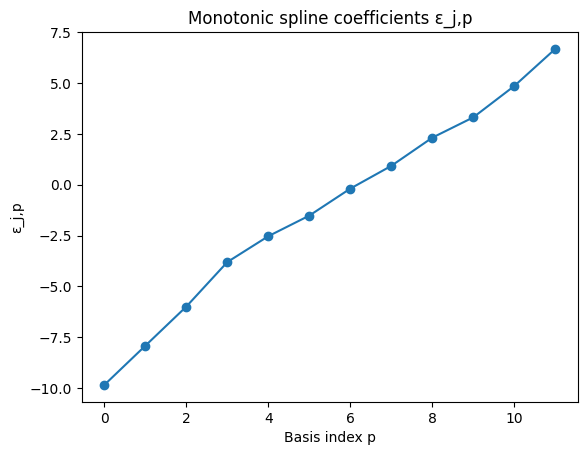

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.1182,  -8.4442,  -6.7702,  -5.0938,  -3.4338,  -1.8628,  -0.4707,
          0.7843,   2.0266,   3.2254,   4.3757,   7.7240])


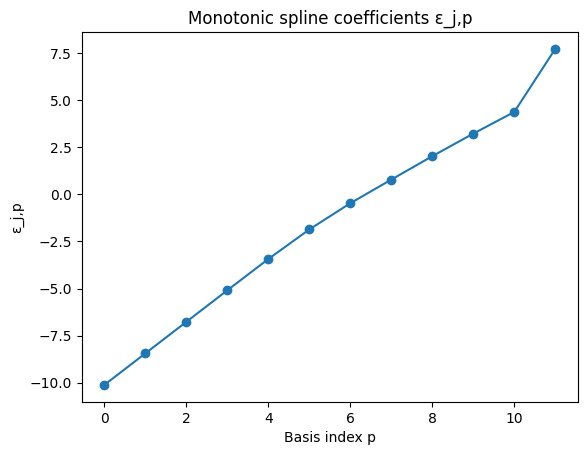

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.5597,  -9.1115,  -7.6633,  -6.2151,  -4.6044,  -0.6456,   2.9869,
          6.5412,   8.3674,  10.1856,  12.0038,  13.8220])


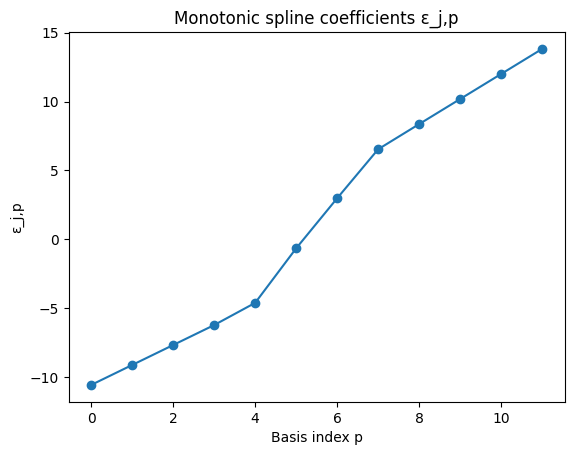

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0116,  -8.3066,  -6.5963,  -4.8913,  -3.1775,  -0.7432,   2.1731,
          5.1313,   8.1152,   9.9334,  11.7516,  13.5698])


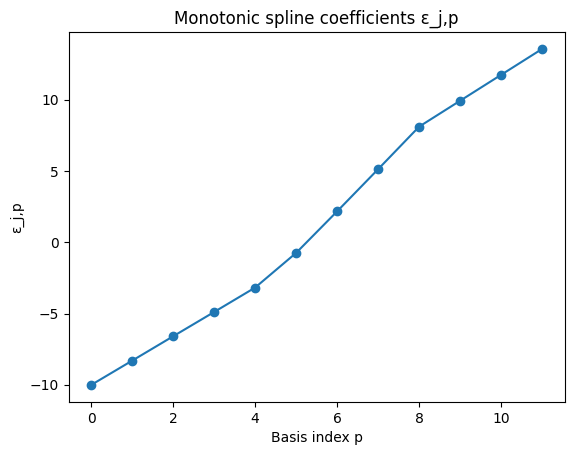

In [25]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

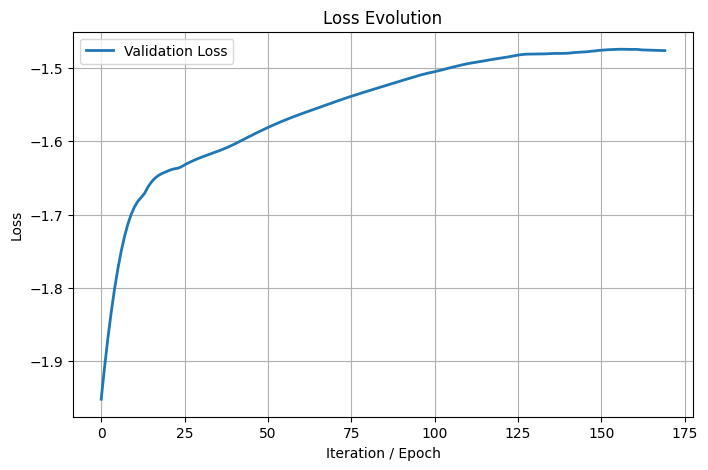

In [26]:
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [28]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [29]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.1397
KLD GTM      Train Data:  -0.0018
KLD Gaussian Train Data:  -0.0006
KLD Copula   Train Data:  -0.0005

KLD BGTM      Test  Data:  0.1353
KLD GTM      Test  Data:  0.0011
KLD Gaussian Test  Data:  0.0004
KLD Copula   Test  Data:  0.0004


In [30]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

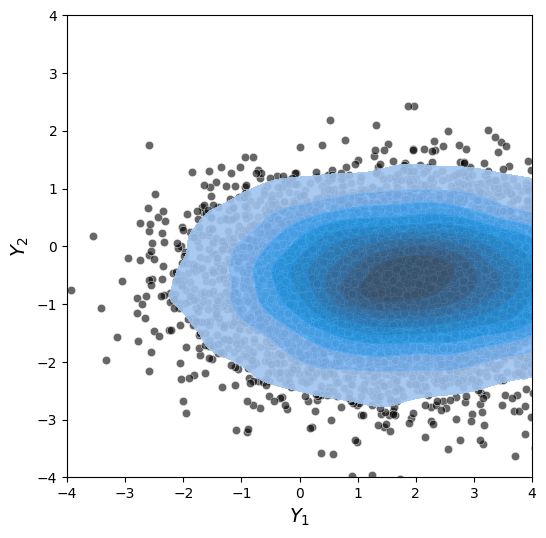

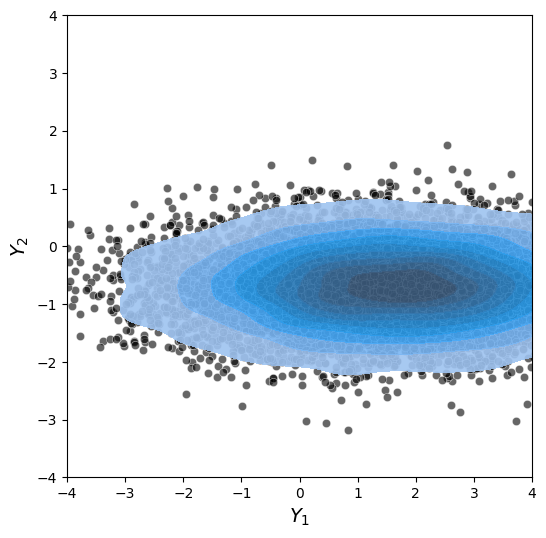

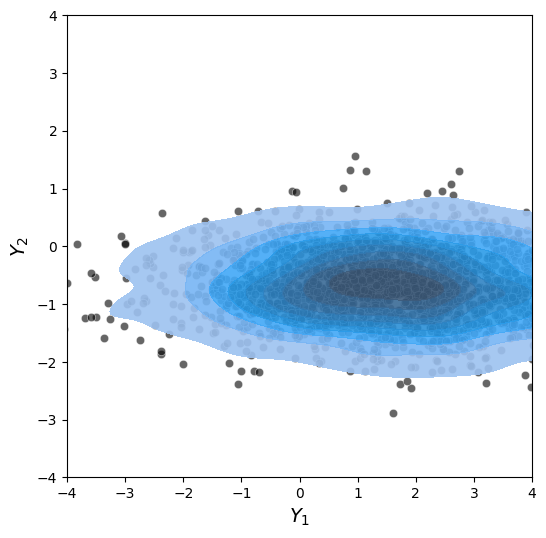

In [31]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

### Independence copula + two-component Gaussian mixture marginals (non-Gaussian)

In [32]:
import numpy as np
import torch
import pyvinecopulib as pv

# Mixture parameters per dimension (same weights across dims for simplicity)
w1 = 0.35  # w2 = 1 - w1
means = torch.tensor([[-2.0,  1.0],   # component 1 means per dim
                      [ 2.0, -1.0]],  # component 2 means per dim
                     dtype=torch.float32)
stds  = torch.tensor([[0.8, 0.5],
                      [0.6, 0.9]], dtype=torch.float32)

def gm2_icdf(u, w1, m, s):
    """
    u: [N, D] tensor in (0,1); w1 scalar; m,s: shape [2, D]
    Returns x: [N, D]
    """
    w2 = 1.0 - w1
    x = torch.empty_like(u)
    mask1 = (u < w1)
    u1 = torch.where(mask1, u / w1, torch.tensor(0.5, dtype=u.dtype))
    u2 = torch.where(~mask1, (u - w1) / w2, torch.tensor(0.5, dtype=u.dtype))
    # invert per dim
    for d in range(u.shape[1]):
        x1 = torch.distributions.Normal(m[0, d], s[0, d]).icdf(u1[:, d])
        x2 = torch.distributions.Normal(m[1, d], s[1, d]).icdf(u2[:, d])
        x[:, d] = torch.where(mask1[:, d], x1, x2)
    return x

def gm2_logpdf(x, w1, m, s):
    w2 = 1.0 - w1
    lp = torch.zeros(x.shape[0])
    for d in range(x.shape[1]):
        lp1 = torch.distributions.Normal(m[0, d], s[0, d]).log_prob(x[:, d])
        lp2 = torch.distributions.Normal(m[1, d], s[1, d]).log_prob(x[:, d])
        # log( w1*e^lp1 + w2*e^lp2 )
        a = torch.stack([lp1 + np.log(w1), lp2 + np.log(w2)], dim=1)
        lp += torch.logsumexp(a, dim=1)
    return lp

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
U_train = torch.tensor(simulated_data_uniform_train).float()
simulated_data_train = gm2_icdf(U_train, w1, means, stds)

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
U_val = torch.tensor(simulated_data_uniform_validate).float()
simulated_data_validate = gm2_icdf(U_val, w1, means, stds)

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
U_test = torch.tensor(simulated_data_uniform_test).float()
simulated_data_test = gm2_icdf(U_test, w1, means, stds)

# ---------- "True" log-likelihoods under independence + GM(2) marginals ----------
loglik_true_train = gm2_logpdf(simulated_data_train, w1, means, stds)
loglik_true_validate = gm2_logpdf(simulated_data_validate, w1, means, stds)
loglik_true_test = gm2_logpdf(simulated_data_test, w1, means, stds)

# ---------- (Optional) crude "estimated" marginals ----------
# For mixtures, proper estimation needs EM or VI. If you just want a baseline,
# you could (very crudely) fit a single Gaussian to each dim:
means_est = simulated_data_train.mean(0)
stds_est  = simulated_data_train.std(0, unbiased=True)
loglik_true_est_train = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_test).sum(1)
# (Use only as a rough reference; your transformation layer should beat this.)


In [33]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_test)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_test)

# BGTM

In [41]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    "RW2": { "tau_a": 1.1, "tau_b": 0.5 },  #E[λ_T] = sehr groß  (smooth but not stiff)
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model


output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


D = 24
First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:00<00:51,  3.87it/s]

ELPD change after μ-nudge: -141.537109375
[1/200] train=41.5540  val_ELPD=-2.0263  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0510 σmin=0.0510 σmax=0.0510   tau4=3.833970419 rank=20  E_qf≈0.0896  tau*E[qf]≈0.3433  Δ=+1.63e+00


  1%|          | 2/200 [00:00<00:47,  4.19it/s]

ELPD change after μ-nudge: -137.05712890625
[2/200] train=40.4989  val_ELPD=-2.0178  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0520 σmin=0.0520 σmax=0.0520   tau4=5.304543753 rank=20  E_qf≈0.0896  tau*E[qf]≈0.475  Δ=+1.47e+00


  2%|▏         | 3/200 [00:00<00:45,  4.30it/s]

ELPD change after μ-nudge: -132.5078125
[3/200] train=41.5403  val_ELPD=-2.0129  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0530 σmin=0.0530 σmax=0.0530   tau4=6.628059754 rank=20  E_qf≈0.0896  tau*E[qf]≈0.5936  Δ=+1.32e+00


  2%|▏         | 4/200 [00:00<00:45,  4.32it/s]

ELPD change after μ-nudge: -127.62158203125
[4/200] train=34.8488  val_ELPD=-2.0115  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0541 σmin=0.0541 σmax=0.0541   tau4=7.819224155 rank=20  E_qf≈0.0896  tau*E[qf]≈0.7002  Δ=+1.19e+00


  2%|▎         | 5/200 [00:01<00:44,  4.34it/s]

ELPD change after μ-nudge: -122.026123046875
[5/200] train=39.7492  val_ELPD=-2.0096  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0551 σmin=0.0551 σmax=0.0551   tau4=8.891272116 rank=20  E_qf≈0.0896  tau*E[qf]≈0.7962  Δ=+1.07e+00


  3%|▎         | 6/200 [00:01<00:44,  4.36it/s]

ELPD change after μ-nudge: -115.893798828125
[6/200] train=35.5713  val_ELPD=-2.0038  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0562 σmin=0.0562 σmax=0.0562   tau4=9.85611528 rank=20  E_qf≈0.0896  tau*E[qf]≈0.8827  Δ=+9.65e-01


  4%|▎         | 7/200 [00:01<00:44,  4.36it/s]

ELPD change after μ-nudge: -109.762451171875
[7/200] train=37.8710  val_ELPD=-2.0000  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0573 σmin=0.0573 σmax=0.0573   tau4=10.72447413 rank=20  E_qf≈0.0896  tau*E[qf]≈0.9604  Δ=+8.68e-01


  4%|▍         | 8/200 [00:01<00:43,  4.38it/s]

ELPD change after μ-nudge: -103.839111328125
[8/200] train=36.6091  val_ELPD=-1.9977  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0584 σmin=0.0584 σmax=0.0584   tau4=11.50599709 rank=20  E_qf≈0.0896  tau*E[qf]≈1.03  Δ=+7.82e-01


  4%|▍         | 9/200 [00:02<00:43,  4.39it/s]

ELPD change after μ-nudge: -98.25439453125
[9/200] train=35.0415  val_ELPD=-1.9967  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0596 σmin=0.0596 σmax=0.0596   tau4=12.20936776 rank=20  E_qf≈0.0896  tau*E[qf]≈1.093  Δ=+7.03e-01


  5%|▌         | 10/200 [00:02<00:43,  4.39it/s]

ELPD change after μ-nudge: -92.666259765625
[10/200] train=35.5149  val_ELPD=-1.9961  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0607 σmin=0.0607 σmax=0.0607   tau4=12.84240136 rank=20  E_qf≈0.0896  tau*E[qf]≈1.15  Δ=+6.33e-01


  6%|▌         | 11/200 [00:02<00:46,  4.07it/s]

ELPD change after μ-nudge: -86.98779296875
[11/200] train=33.7163  val_ELPD=-1.9959  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0619 σmin=0.0619 σmax=0.0619   tau4=13.4121316 rank=20  E_qf≈0.0896  tau*E[qf]≈1.201  Δ=+5.70e-01


  6%|▌         | 12/200 [00:02<00:48,  3.87it/s]

ELPD change after μ-nudge: -81.601806640625
[12/200] train=36.4558  val_ELPD=-1.9960  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0631 σmin=0.0631 σmax=0.0631   tau4=13.92488882 rank=20  E_qf≈0.0896  tau*E[qf]≈1.247  Δ=+5.13e-01


  6%|▋         | 13/200 [00:03<00:49,  3.75it/s]

ELPD change after μ-nudge: -76.529052734375
[13/200] train=34.9500  val_ELPD=-1.9957  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0644 σmin=0.0644 σmax=0.0644   tau4=14.38637031 rank=20  E_qf≈0.0896  tau*E[qf]≈1.288  Δ=+4.61e-01


  7%|▋         | 14/200 [00:03<00:50,  3.67it/s]

ELPD change after μ-nudge: -72.026611328125
[14/200] train=34.8406  val_ELPD=-1.9941  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0656 σmin=0.0656 σmax=0.0656   tau4=14.80170366 rank=20  E_qf≈0.0896  tau*E[qf]≈1.326  Δ=+4.15e-01


  8%|▊         | 15/200 [00:03<00:51,  3.60it/s]

ELPD change after μ-nudge: -69.080322265625
[15/200] train=32.4191  val_ELPD=-1.9924  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0669 σmin=0.0669 σmax=0.0669   tau4=15.17550367 rank=20  E_qf≈0.0896  tau*E[qf]≈1.359  Δ=+3.74e-01


  8%|▊         | 16/200 [00:04<00:51,  3.57it/s]

ELPD change after μ-nudge: -67.248291015625
[16/200] train=31.5880  val_ELPD=-1.9905  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0682 σmin=0.0682 σmax=0.0682   tau4=15.51192368 rank=20  E_qf≈0.0896  tau*E[qf]≈1.389  Δ=+3.36e-01


  8%|▊         | 17/200 [00:04<00:56,  3.26it/s]

ELPD change after μ-nudge: -66.109619140625
[17/200] train=34.0643  val_ELPD=-1.9882  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0695 σmin=0.0695 σmax=0.0696   tau4=15.81470168 rank=20  E_qf≈0.0896  tau*E[qf]≈1.416  Δ=+3.03e-01


  9%|▉         | 18/200 [00:04<01:00,  2.99it/s]

ELPD change after μ-nudge: -65.761962890625
[18/200] train=31.7183  val_ELPD=-1.9857  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0709 σmin=0.0709 σmax=0.0709   tau4=16.08720189 rank=20  E_qf≈0.0896  tau*E[qf]≈1.441  Δ=+2.73e-01


 10%|▉         | 19/200 [00:05<00:57,  3.12it/s]

ELPD change after μ-nudge: -65.887451171875
[19/200] train=31.3722  val_ELPD=-1.9828  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0723 σmin=0.0723 σmax=0.0723   tau4=16.33245208 rank=20  E_qf≈0.0896  tau*E[qf]≈1.463  Δ=+2.45e-01


 10%|█         | 20/200 [00:05<00:55,  3.22it/s]

ELPD change after μ-nudge: -66.596923828125
[20/200] train=31.1893  val_ELPD=-1.9797  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0737 σmin=0.0737 σmax=0.0737   tau4=16.55317725 rank=20  E_qf≈0.0896  tau*E[qf]≈1.482  Δ=+2.21e-01


 10%|█         | 21/200 [00:05<01:00,  2.96it/s]

ELPD change after μ-nudge: -67.96142578125
[21/200] train=30.9184  val_ELPD=-1.9764  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0751 σmin=0.0751 σmax=0.0751   tau4=16.7518299 rank=20  E_qf≈0.0896  tau*E[qf]≈1.5  Δ=+1.99e-01


 11%|█         | 22/200 [00:06<01:04,  2.78it/s]

ELPD change after μ-nudge: -69.797119140625
[22/200] train=30.1513  val_ELPD=-1.9728  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0766 σmin=0.0766 σmax=0.0766   tau4=16.93061729 rank=20  E_qf≈0.0896  tau*E[qf]≈1.516  Δ=+1.79e-01


 12%|█▏        | 23/200 [00:06<01:06,  2.68it/s]

ELPD change after μ-nudge: -72.171875
[23/200] train=28.5289  val_ELPD=-1.9689  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0781 σmin=0.0780 σmax=0.0781   tau4=17.09152593 rank=20  E_qf≈0.0896  tau*E[qf]≈1.531  Δ=+1.61e-01


 12%|█▏        | 24/200 [00:06<01:07,  2.61it/s]

ELPD change after μ-nudge: -75.0283203125
[24/200] train=30.2860  val_ELPD=-1.9650  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0796 σmin=0.0796 σmax=0.0796   tau4=17.23634372 rank=20  E_qf≈0.0896  tau*E[qf]≈1.544  Δ=+1.45e-01


 12%|█▎        | 25/200 [00:07<01:08,  2.56it/s]

ELPD change after μ-nudge: -78.161865234375
[25/200] train=29.0611  val_ELPD=-1.9611  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0811 σmin=0.0811 σmax=0.0811   tau4=17.36667972 rank=20  E_qf≈0.0896  tau*E[qf]≈1.555  Δ=+1.30e-01


 13%|█▎        | 26/200 [00:07<01:08,  2.53it/s]

ELPD change after μ-nudge: -81.880615234375
[26/200] train=27.7100  val_ELPD=-1.9570  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0827 σmin=0.0827 σmax=0.0827   tau4=17.48398212 rank=20  E_qf≈0.0896  tau*E[qf]≈1.566  Δ=+1.17e-01


 14%|█▎        | 27/200 [00:08<01:08,  2.51it/s]

ELPD change after μ-nudge: -85.74560546875
[27/200] train=28.7792  val_ELPD=-1.9529  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0843 σmin=0.0843 σmax=0.0843   tau4=17.58955429 rank=20  E_qf≈0.0896  tau*E[qf]≈1.575  Δ=+1.06e-01


 14%|█▍        | 28/200 [00:08<01:08,  2.50it/s]

ELPD change after μ-nudge: -89.81787109375
[28/200] train=27.9511  val_ELPD=-1.9489  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0859 σmin=0.0859 σmax=0.0859   tau4=17.68456924 rank=20  E_qf≈0.0896  tau*E[qf]≈1.584  Δ=+9.50e-02


 14%|█▍        | 29/200 [00:09<01:08,  2.49it/s]

ELPD change after μ-nudge: -93.96484375
[29/200] train=26.8857  val_ELPD=-1.9452  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0875 σmin=0.0875 σmax=0.0876   tau4=17.77008269 rank=20  E_qf≈0.0896  tau*E[qf]≈1.591  Δ=+8.55e-02


 15%|█▌        | 30/200 [00:09<01:08,  2.48it/s]

ELPD change after μ-nudge: -98.19091796875
[30/200] train=26.1605  val_ELPD=-1.9416  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0892 σmin=0.0892 σmax=0.0892   tau4=17.8470448 rank=20  E_qf≈0.0896  tau*E[qf]≈1.598  Δ=+7.70e-02


 16%|█▌        | 31/200 [00:10<01:19,  2.11it/s]

ELPD change after μ-nudge: -102.114990234375
[31/200] train=25.5219  val_ELPD=-1.9383  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0909 σmin=0.0909 σmax=0.0910   tau4=17.91631069 rank=20  E_qf≈0.0896  tau*E[qf]≈1.604  Δ=+6.93e-02


 16%|█▌        | 32/200 [00:10<01:28,  1.91it/s]

ELPD change after μ-nudge: -105.82861328125
[32/200] train=25.4020  val_ELPD=-1.9351  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0927 σmin=0.0927 σmax=0.0927   tau4=17.97865 rank=20  E_qf≈0.0896  tau*E[qf]≈1.61  Δ=+6.23e-02


 16%|█▋        | 33/200 [00:11<01:33,  1.78it/s]

ELPD change after μ-nudge: -109.5263671875
[33/200] train=24.6652  val_ELPD=-1.9321  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0945 σmin=0.0945 σmax=0.0945   tau4=18.03475538 rank=20  E_qf≈0.0896  tau*E[qf]≈1.615  Δ=+5.61e-02


 17%|█▋        | 34/200 [00:11<01:37,  1.71it/s]

ELPD change after μ-nudge: -112.97607421875
[34/200] train=24.7837  val_ELPD=-1.9293  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0963 σmin=0.0963 σmax=0.0963   tau4=18.08525021 rank=20  E_qf≈0.0896  tau*E[qf]≈1.62  Δ=+5.05e-02


 18%|█▊        | 35/200 [00:12<01:39,  1.66it/s]

ELPD change after μ-nudge: -116.22607421875
[35/200] train=24.5990  val_ELPD=-1.9262  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0981 σmin=0.0981 σmax=0.0981   tau4=18.13069557 rank=20  E_qf≈0.0896  tau*E[qf]≈1.624  Δ=+4.54e-02


 18%|█▊        | 36/200 [00:13<01:41,  1.62it/s]

ELPD change after μ-nudge: -119.0439453125
[36/200] train=23.7099  val_ELPD=-1.9231  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1000 σmin=0.1000 σmax=0.1000   tau4=18.17159639 rank=20  E_qf≈0.0896  tau*E[qf]≈1.627  Δ=+4.09e-02


 18%|█▊        | 37/200 [00:13<01:41,  1.60it/s]

ELPD change after μ-nudge: -121.55419921875
[37/200] train=22.9119  val_ELPD=-1.9200  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1019 σmin=0.1019 σmax=0.1019   tau4=18.20840713 rank=20  E_qf≈0.0896  tau*E[qf]≈1.631  Δ=+3.68e-02


 19%|█▉        | 38/200 [00:14<01:42,  1.59it/s]

ELPD change after μ-nudge: -123.668212890625
[38/200] train=22.6480  val_ELPD=-1.9170  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1038 σmin=0.1038 σmax=0.1038   tau4=18.24153679 rank=20  E_qf≈0.0896  tau*E[qf]≈1.634  Δ=+3.31e-02


 20%|█▉        | 39/200 [00:15<01:42,  1.57it/s]

ELPD change after μ-nudge: -125.593505859375
[39/200] train=22.5576  val_ELPD=-1.9142  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1058 σmin=0.1058 σmax=0.1058   tau4=18.27135349 rank=20  E_qf≈0.0896  tau*E[qf]≈1.636  Δ=+2.98e-02


 20%|██        | 40/200 [00:15<01:41,  1.57it/s]

ELPD change after μ-nudge: -127.1181640625
[40/200] train=22.0487  val_ELPD=-1.9115  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1078 σmin=0.1078 σmax=0.1078   tau4=18.29818851 rank=20  E_qf≈0.0896  tau*E[qf]≈1.639  Δ=+2.68e-02


 20%|██        | 41/200 [00:17<02:05,  1.27it/s]

ELPD change after μ-nudge: -128.572509765625
[41/200] train=21.5371  val_ELPD=-1.9089  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1099 σmin=0.1098 σmax=0.1099   tau4=18.32234004 rank=20  E_qf≈0.0896  tau*E[qf]≈1.641  Δ=+2.42e-02


 21%|██        | 42/200 [00:18<02:20,  1.12it/s]

ELPD change after μ-nudge: -129.80419921875
[42/200] train=21.2889  val_ELPD=-1.9064  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1119 σmin=0.1119 σmax=0.1120   tau4=18.34407641 rank=20  E_qf≈0.0896  tau*E[qf]≈1.643  Δ=+2.17e-02


 22%|██▏       | 43/200 [00:19<02:30,  1.04it/s]

ELPD change after μ-nudge: -131.121337890625
[43/200] train=20.6505  val_ELPD=-1.9041  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1141 σmin=0.1140 σmax=0.1141   tau4=18.36363915 rank=20  E_qf≈0.0896  tau*E[qf]≈1.645  Δ=+1.96e-02


 22%|██▏       | 44/200 [00:20<02:37,  1.01s/it]

ELPD change after μ-nudge: -132.13134765625
[44/200] train=20.3137  val_ELPD=-1.9020  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1162 σmin=0.1162 σmax=0.1162   tau4=18.38124561 rank=20  E_qf≈0.0896  tau*E[qf]≈1.646  Δ=+1.76e-02


 22%|██▎       | 45/200 [00:21<02:41,  1.04s/it]

ELPD change after μ-nudge: -133.25634765625
[45/200] train=19.4837  val_ELPD=-1.9000  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1184 σmin=0.1184 σmax=0.1184   tau4=18.39709142 rank=20  E_qf≈0.0896  tau*E[qf]≈1.648  Δ=+1.58e-02


 23%|██▎       | 46/200 [00:22<02:44,  1.07s/it]

ELPD change after μ-nudge: -134.666748046875
[46/200] train=19.5934  val_ELPD=-1.8979  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1206 σmin=0.1206 σmax=0.1206   tau4=18.41135266 rank=20  E_qf≈0.0896  tau*E[qf]≈1.649  Δ=+1.43e-02


 24%|██▎       | 47/200 [00:23<02:46,  1.09s/it]

ELPD change after μ-nudge: -136.015869140625
[47/200] train=18.2337  val_ELPD=-1.8950  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1229 σmin=0.1228 σmax=0.1229   tau4=18.42418777 rank=20  E_qf≈0.0896  tau*E[qf]≈1.65  Δ=+1.28e-02


 24%|██▍       | 48/200 [00:24<02:47,  1.10s/it]

ELPD change after μ-nudge: -137.25537109375
[48/200] train=18.9367  val_ELPD=-1.8920  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1252 σmin=0.1251 σmax=0.1252   tau4=18.43573937 rank=20  E_qf≈0.0896  tau*E[qf]≈1.651  Δ=+1.16e-02


 24%|██▍       | 49/200 [00:26<02:48,  1.11s/it]

ELPD change after μ-nudge: -138.359375
[49/200] train=17.8378  val_ELPD=-1.8891  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1275 σmin=0.1275 σmax=0.1276   tau4=18.44613581 rank=20  E_qf≈0.0896  tau*E[qf]≈1.652  Δ=+1.04e-02


 25%|██▌       | 50/200 [00:27<02:51,  1.14s/it]

ELPD change after μ-nudge: -139.2470703125
[50/200] train=17.4777  val_ELPD=-1.8864  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1299 σmin=0.1299 σmax=0.1300   tau4=18.4554926 rank=20  E_qf≈0.0896  tau*E[qf]≈1.653  Δ=+9.36e-03


 26%|██▌       | 51/200 [00:28<02:49,  1.14s/it]

ELPD change after μ-nudge: -139.28759765625
[51/200] train=17.0431  val_ELPD=-1.8840  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1323 σmin=0.1323 σmax=0.1324   tau4=18.46391372 rank=20  E_qf≈0.0896  tau*E[qf]≈1.654  Δ=+8.42e-03


 26%|██▌       | 52/200 [00:29<02:48,  1.14s/it]

ELPD change after μ-nudge: -139.5263671875
[52/200] train=16.5869  val_ELPD=-1.8816  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1348 σmin=0.1347 σmax=0.1348   tau4=18.47149272 rank=20  E_qf≈0.0896  tau*E[qf]≈1.654  Δ=+7.58e-03


 26%|██▋       | 53/200 [00:30<02:47,  1.14s/it]

ELPD change after μ-nudge: -139.35009765625
[53/200] train=15.6888  val_ELPD=-1.8793  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1373 σmin=0.1372 σmax=0.1374   tau4=18.47831383 rank=20  E_qf≈0.0896  tau*E[qf]≈1.655  Δ=+6.82e-03


 27%|██▋       | 54/200 [00:31<02:46,  1.14s/it]

ELPD change after μ-nudge: -138.986572265625
[54/200] train=15.4869  val_ELPD=-1.8772  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1399 σmin=0.1398 σmax=0.1399   tau4=18.48445282 rank=20  E_qf≈0.0896  tau*E[qf]≈1.655  Δ=+6.14e-03


 28%|██▊       | 55/200 [00:32<02:44,  1.13s/it]

ELPD change after μ-nudge: -139.09130859375
[55/200] train=15.7768  val_ELPD=-1.8751  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1424 σmin=0.1424 σmax=0.1425   tau4=18.48997791 rank=20  E_qf≈0.0896  tau*E[qf]≈1.656  Δ=+5.53e-03


 28%|██▊       | 56/200 [00:34<02:43,  1.13s/it]

ELPD change after μ-nudge: -139.437744140625
[56/200] train=14.6838  val_ELPD=-1.8730  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1451 σmin=0.1450 σmax=0.1451   tau4=18.4949505 rank=20  E_qf≈0.0896  tau*E[qf]≈1.656  Δ=+4.97e-03


 28%|██▊       | 57/200 [00:35<02:41,  1.13s/it]

ELPD change after μ-nudge: -140.131103515625
[57/200] train=14.7594  val_ELPD=-1.8710  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1478 σmin=0.1477 σmax=0.1478   tau4=18.49942583 rank=20  E_qf≈0.0896  tau*E[qf]≈1.657  Δ=+4.48e-03


 29%|██▉       | 58/200 [00:36<02:40,  1.13s/it]

ELPD change after μ-nudge: -140.380859375
[58/200] train=13.5488  val_ELPD=-1.8691  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1505 σmin=0.1504 σmax=0.1505   tau4=18.50345362 rank=20  E_qf≈0.0896  tau*E[qf]≈1.657  Δ=+4.03e-03


 30%|██▉       | 59/200 [00:37<02:47,  1.19s/it]

ELPD change after μ-nudge: -140.33544921875
[59/200] train=13.5983  val_ELPD=-1.8673  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1532 σmin=0.1531 σmax=0.1533   tau4=18.50707863 rank=20  E_qf≈0.0896  tau*E[qf]≈1.657  Δ=+3.63e-03


 30%|███       | 60/200 [00:38<02:43,  1.17s/it]

ELPD change after μ-nudge: -141.12353515625
[60/200] train=13.3665  val_ELPD=-1.8654  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1560 σmin=0.1559 σmax=0.1561   tau4=18.51034115 rank=20  E_qf≈0.0896  tau*E[qf]≈1.658  Δ=+3.26e-03


 30%|███       | 61/200 [00:39<02:40,  1.16s/it]

ELPD change after μ-nudge: -143.29833984375
[61/200] train=12.6611  val_ELPD=-1.8632  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1589 σmin=0.1588 σmax=0.1590   tau4=18.51327741 rank=20  E_qf≈0.0896  tau*E[qf]≈1.658  Δ=+2.94e-03


 31%|███       | 62/200 [00:41<02:39,  1.15s/it]

ELPD change after μ-nudge: -145.910400390625
[62/200] train=12.7831  val_ELPD=-1.8609  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1618 σmin=0.1617 σmax=0.1619   tau4=18.51592004 rank=20  E_qf≈0.0896  tau*E[qf]≈1.658  Δ=+2.64e-03


 32%|███▏      | 63/200 [00:42<02:37,  1.15s/it]

ELPD change after μ-nudge: -148.76953125
[63/200] train=11.8092  val_ELPD=-1.8587  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1647 σmin=0.1646 σmax=0.1648   tau4=18.51829841 rank=20  E_qf≈0.0896  tau*E[qf]≈1.658  Δ=+2.38e-03


 32%|███▏      | 64/200 [00:43<02:35,  1.14s/it]

ELPD change after μ-nudge: -151.534423828125
[64/200] train=10.8291  val_ELPD=-1.8566  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1677 σmin=0.1676 σmax=0.1678   tau4=18.52043895 rank=20  E_qf≈0.0896  tau*E[qf]≈1.659  Δ=+2.14e-03


 32%|███▎      | 65/200 [00:44<02:33,  1.14s/it]

ELPD change after μ-nudge: -154.68310546875
[65/200] train=10.4977  val_ELPD=-1.8544  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1708 σmin=0.1706 σmax=0.1709   tau4=18.52236543 rank=20  E_qf≈0.0896  tau*E[qf]≈1.659  Δ=+1.93e-03


 33%|███▎      | 66/200 [00:45<02:32,  1.13s/it]

ELPD change after μ-nudge: -157.8369140625
[66/200] train=10.7833  val_ELPD=-1.8524  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1739 σmin=0.1737 σmax=0.1740   tau4=18.52409926 rank=20  E_qf≈0.0896  tau*E[qf]≈1.659  Δ=+1.73e-03


 34%|███▎      | 67/200 [00:46<02:30,  1.13s/it]

ELPD change after μ-nudge: -161.30517578125
[67/200] train=10.1637  val_ELPD=-1.8502  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1770 σmin=0.1768 σmax=0.1771   tau4=18.52565971 rank=20  E_qf≈0.0896  tau*E[qf]≈1.659  Δ=+1.56e-03


 34%|███▍      | 68/200 [00:47<02:29,  1.13s/it]

ELPD change after μ-nudge: -164.952880859375
[68/200] train=9.0371  val_ELPD=-1.8481  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1802 σmin=0.1800 σmax=0.1803   tau4=18.52706412 rank=20  E_qf≈0.0896  tau*E[qf]≈1.659  Δ=+1.40e-03


 34%|███▍      | 69/200 [00:48<02:28,  1.13s/it]

ELPD change after μ-nudge: -167.578369140625
[69/200] train=9.8149  val_ELPD=-1.8463  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1834 σmin=0.1832 σmax=0.1835   tau4=18.52832808 rank=20  E_qf≈0.0896  tau*E[qf]≈1.659  Δ=+1.26e-03


 35%|███▌      | 70/200 [00:50<02:27,  1.13s/it]

ELPD change after μ-nudge: -172.060791015625
[70/200] train=8.4630  val_ELPD=-1.8440  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1867 σmin=0.1864 σmax=0.1868   tau4=18.52946565 rank=20  E_qf≈0.0896  tau*E[qf]≈1.659  Δ=+1.14e-03


 36%|███▌      | 71/200 [00:51<02:25,  1.13s/it]

ELPD change after μ-nudge: -178.605712890625
[71/200] train=8.1388  val_ELPD=-1.8415  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1900 σmin=0.1898 σmax=0.1902   tau4=18.53048946 rank=20  E_qf≈0.0896  tau*E[qf]≈1.659  Δ=+1.02e-03


 36%|███▌      | 72/200 [00:52<02:24,  1.13s/it]

ELPD change after μ-nudge: -185.73388671875
[72/200] train=7.6081  val_ELPD=-1.8391  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1934 σmin=0.1931 σmax=0.1936   tau4=18.53141089 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+9.21e-04


 36%|███▋      | 73/200 [00:53<02:23,  1.13s/it]

ELPD change after μ-nudge: -191.35986328125
[73/200] train=8.2174  val_ELPD=-1.8371  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1968 σmin=0.1965 σmax=0.1970   tau4=18.53224018 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+8.29e-04


 37%|███▋      | 74/200 [00:54<02:22,  1.13s/it]

ELPD change after μ-nudge: -197.177978515625
[74/200] train=7.7574  val_ELPD=-1.8352  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2003 σmin=0.2000 σmax=0.2005   tau4=18.53298654 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+7.46e-04


 38%|███▊      | 75/200 [00:55<02:21,  1.13s/it]

ELPD change after μ-nudge: -201.58203125
[75/200] train=6.1226  val_ELPD=-1.8335  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2039 σmin=0.2035 σmax=0.2041   tau4=18.53365826 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+6.72e-04


 38%|███▊      | 76/200 [00:56<02:20,  1.13s/it]

ELPD change after μ-nudge: -203.798583984375
[76/200] train=5.8859  val_ELPD=-1.8320  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2074 σmin=0.2070 σmax=0.2077   tau4=18.53426281 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+6.05e-04


 38%|███▊      | 77/200 [00:57<02:18,  1.13s/it]

ELPD change after μ-nudge: -205.5791015625
[77/200] train=6.3479  val_ELPD=-1.8307  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2111 σmin=0.2107 σmax=0.2113   tau4=18.53480691 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+5.44e-04


 39%|███▉      | 78/200 [00:59<02:17,  1.13s/it]

ELPD change after μ-nudge: -206.520263671875
[78/200] train=5.0736  val_ELPD=-1.8294  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2148 σmin=0.2143 σmax=0.2150   tau4=18.53529659 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+4.90e-04


 40%|███▉      | 79/200 [01:00<02:17,  1.13s/it]

ELPD change after μ-nudge: -205.474365234375
[79/200] train=5.2049  val_ELPD=-1.8285  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2185 σmin=0.2180 σmax=0.2188   tau4=18.53573731 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+4.41e-04


 40%|████      | 80/200 [01:01<02:16,  1.13s/it]

ELPD change after μ-nudge: -205.317626953125
[80/200] train=4.7447  val_ELPD=-1.8275  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2223 σmin=0.2218 σmax=0.2226   tau4=18.53613395 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+3.97e-04


 40%|████      | 81/200 [01:02<02:14,  1.13s/it]

ELPD change after μ-nudge: -203.873291015625
[81/200] train=4.1449  val_ELPD=-1.8267  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2262 σmin=0.2257 σmax=0.2265   tau4=18.53649093 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+3.57e-04


 41%|████      | 82/200 [01:03<02:13,  1.13s/it]

ELPD change after μ-nudge: -203.277587890625
[82/200] train=3.3290  val_ELPD=-1.8259  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2301 σmin=0.2295 σmax=0.2305   tau4=18.53681222 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+3.21e-04


 42%|████▏     | 83/200 [01:04<02:12,  1.13s/it]

ELPD change after μ-nudge: -203.388671875
[83/200] train=3.4481  val_ELPD=-1.8249  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2341 σmin=0.2335 σmax=0.2344   tau4=18.53710137 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+2.89e-04


 42%|████▏     | 84/200 [01:05<02:11,  1.13s/it]

ELPD change after μ-nudge: -206.111572265625
[84/200] train=2.2481  val_ELPD=-1.8233  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2381 σmin=0.2375 σmax=0.2385   tau4=18.53736161 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+2.60e-04


 42%|████▎     | 85/200 [01:07<02:09,  1.13s/it]

ELPD change after μ-nudge: -211.156982421875
[85/200] train=2.6380  val_ELPD=-1.8212  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2422 σmin=0.2415 σmax=0.2426   tau4=18.53759583 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+2.34e-04


 43%|████▎     | 86/200 [01:08<02:08,  1.13s/it]

ELPD change after μ-nudge: -217.61279296875
[86/200] train=2.4335  val_ELPD=-1.8189  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2463 σmin=0.2456 σmax=0.2468   tau4=18.53780662 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+2.11e-04


 44%|████▎     | 87/200 [01:09<02:07,  1.13s/it]

ELPD change after μ-nudge: -222.7685546875
[87/200] train=1.1739  val_ELPD=-1.8167  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2505 σmin=0.2498 σmax=0.2510   tau4=18.53799633 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.90e-04


 44%|████▍     | 88/200 [01:10<02:06,  1.13s/it]

ELPD change after μ-nudge: -227.23388671875
[88/200] train=1.2100  val_ELPD=-1.8149  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2548 σmin=0.2540 σmax=0.2553   tau4=18.53816708 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.71e-04


 44%|████▍     | 89/200 [01:11<02:05,  1.13s/it]

ELPD change after μ-nudge: -233.906982421875
[89/200] train=0.6522  val_ELPD=-1.8128  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2591 σmin=0.2583 σmax=0.2596   tau4=18.53832074 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.54e-04


 45%|████▌     | 90/200 [01:12<02:04,  1.13s/it]

ELPD change after μ-nudge: -245.4580078125
[90/200] train=-0.0559  val_ELPD=-1.8103  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2634 σmin=0.2626 σmax=0.2640   tau4=18.53845905 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.38e-04


 46%|████▌     | 91/200 [01:13<02:03,  1.13s/it]

ELPD change after μ-nudge: -255.80078125
[91/200] train=-0.0377  val_ELPD=-1.8080  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2678 σmin=0.2669 σmax=0.2685   tau4=18.53858352 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.24e-04


 46%|████▌     | 92/200 [01:14<02:02,  1.13s/it]

ELPD change after μ-nudge: -263.680419921875
[92/200] train=-0.0793  val_ELPD=-1.8061  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2723 σmin=0.2714 σmax=0.2730   tau4=18.53869554 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.12e-04


 46%|████▋     | 93/200 [01:16<02:01,  1.13s/it]

ELPD change after μ-nudge: -270.41748046875
[93/200] train=-0.6726  val_ELPD=-1.8043  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2769 σmin=0.2758 σmax=0.2776   tau4=18.53879636 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.01e-04


 47%|████▋     | 94/200 [01:17<01:59,  1.13s/it]

ELPD change after μ-nudge: -278.05224609375
[94/200] train=-1.7124  val_ELPD=-1.8025  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2815 σmin=0.2804 σmax=0.2822   tau4=18.5388871 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+9.07e-05


 48%|████▊     | 95/200 [01:18<01:58,  1.13s/it]

ELPD change after μ-nudge: -286.919677734375
[95/200] train=-1.5931  val_ELPD=-1.8006  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2861 σmin=0.2849 σmax=0.2869   tau4=18.53896877 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+8.17e-05


 48%|████▊     | 96/200 [01:19<01:57,  1.13s/it]

ELPD change after μ-nudge: -296.2529296875
[96/200] train=-1.9868  val_ELPD=-1.7988  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2908 σmin=0.2896 σmax=0.2917   tau4=18.53904227 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+7.35e-05


 48%|████▊     | 97/200 [01:20<01:56,  1.13s/it]

ELPD change after μ-nudge: -307.52001953125
[97/200] train=-2.6365  val_ELPD=-1.7971  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2956 σmin=0.2943 σmax=0.2965   tau4=18.53910842 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+6.61e-05


 49%|████▉     | 98/200 [01:21<01:55,  1.13s/it]

ELPD change after μ-nudge: -319.30859375
[98/200] train=-2.2635  val_ELPD=-1.7956  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3004 σmin=0.2990 σmax=0.3014   tau4=18.53916795 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+5.95e-05


 50%|████▉     | 99/200 [01:22<01:54,  1.13s/it]

ELPD change after μ-nudge: -334.294677734375
[99/200] train=-3.5983  val_ELPD=-1.7943  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3053 σmin=0.3038 σmax=0.3063   tau4=18.53922153 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+5.36e-05


 50%|█████     | 100/200 [01:23<01:52,  1.13s/it]

ELPD change after μ-nudge: -344.94287109375
[100/200] train=-3.8284  val_ELPD=-1.7931  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3103 σmin=0.3087 σmax=0.3113   tau4=18.53926976 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+4.82e-05


 50%|█████     | 101/200 [01:25<01:51,  1.13s/it]

ELPD change after μ-nudge: -347.970703125
[101/200] train=-3.8614  val_ELPD=-1.7920  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3153 σmin=0.3137 σmax=0.3164   tau4=18.53931316 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+4.34e-05


 51%|█████     | 102/200 [01:26<01:50,  1.13s/it]

ELPD change after μ-nudge: -349.90234375
[102/200] train=-4.0093  val_ELPD=-1.7910  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3204 σmin=0.3187 σmax=0.3215   tau4=18.53935222 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+3.91e-05


 52%|█████▏    | 103/200 [01:27<01:49,  1.13s/it]

ELPD change after μ-nudge: -348.321044921875
[103/200] train=-4.4690  val_ELPD=-1.7903  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3255 σmin=0.3237 σmax=0.3267   tau4=18.53938737 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+3.52e-05


 52%|█████▏    | 104/200 [01:28<01:48,  1.13s/it]

ELPD change after μ-nudge: -341.9833984375
[104/200] train=-4.7967  val_ELPD=-1.7903  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3307 σmin=0.3288 σmax=0.3320   tau4=18.53941901 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+3.16e-05


 52%|█████▎    | 105/200 [01:29<01:47,  1.13s/it]

ELPD change after μ-nudge: -334.159423828125
[105/200] train=-5.1536  val_ELPD=-1.7909  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3360 σmin=0.3340 σmax=0.3373   tau4=18.53944749 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+2.85e-05


 53%|█████▎    | 106/200 [01:30<01:46,  1.13s/it]

ELPD change after μ-nudge: -334.648681640625
[106/200] train=-5.9854  val_ELPD=-1.7908  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3413 σmin=0.3392 σmax=0.3427   tau4=18.53947311 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+2.56e-05


 54%|█████▎    | 107/200 [01:31<01:45,  1.13s/it]

ELPD change after μ-nudge: -332.59375
[107/200] train=-6.3514  val_ELPD=-1.7913  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3467 σmin=0.3444 σmax=0.3482   tau4=18.53949618 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+2.31e-05


 54%|█████▍    | 108/200 [01:33<01:43,  1.13s/it]

ELPD change after μ-nudge: -332.712646484375
[108/200] train=-6.8267  val_ELPD=-1.7914  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3521 σmin=0.3497 σmax=0.3537   tau4=18.53951694 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+2.08e-05


 55%|█████▍    | 109/200 [01:34<01:42,  1.13s/it]

ELPD change after μ-nudge: -331.581298828125
[109/200] train=-6.7106  val_ELPD=-1.7919  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3576 σmin=0.3551 σmax=0.3593   tau4=18.53953562 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.87e-05


 55%|█████▌    | 110/200 [01:35<01:46,  1.18s/it]

ELPD change after μ-nudge: -338.87158203125
[110/200] train=-6.7561  val_ELPD=-1.7911  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3631 σmin=0.3605 σmax=0.3649   tau4=18.53955243 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.68e-05


 56%|█████▌    | 111/200 [01:36<01:43,  1.17s/it]

ELPD change after μ-nudge: -341.737060546875
[111/200] train=-6.9496  val_ELPD=-1.7907  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3659 σmin=0.3632 σmax=0.3678   tau4=18.53956757 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.51e-05


 56%|█████▌    | 112/200 [01:37<01:41,  1.16s/it]

ELPD change after μ-nudge: -342.24462890625
[112/200] train=-7.8142  val_ELPD=-1.7908  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3687 σmin=0.3660 σmax=0.3706   tau4=18.53958119 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.36e-05


 56%|█████▋    | 113/200 [01:38<01:39,  1.15s/it]

ELPD change after μ-nudge: -343.507080078125
[113/200] train=-7.9170  val_ELPD=-1.7908  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3716 σmin=0.3687 σmax=0.3735   tau4=18.53959344 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.23e-05


 57%|█████▋    | 114/200 [01:39<01:38,  1.14s/it]

ELPD change after μ-nudge: -346.530517578125
[114/200] train=-7.9947  val_ELPD=-1.7903  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3744 σmin=0.3714 σmax=0.3764   tau4=18.53960448 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.10e-05


 57%|█████▊    | 115/200 [01:41<01:36,  1.14s/it]

ELPD change after μ-nudge: -354.4130859375
[115/200] train=-8.9250  val_ELPD=-1.7893  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3772 σmin=0.3742 σmax=0.3793   tau4=18.5396144 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+9.93e-06


 58%|█████▊    | 116/200 [01:42<01:35,  1.14s/it]

ELPD change after μ-nudge: -362.812255859375
[116/200] train=-8.1653  val_ELPD=-1.7883  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3801 σmin=0.3770 σmax=0.3822   tau4=18.53962334 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+8.94e-06


 58%|█████▊    | 117/200 [01:43<01:34,  1.14s/it]

ELPD change after μ-nudge: -371.029296875
[117/200] train=-7.7818  val_ELPD=-1.7872  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3830 σmin=0.3798 σmax=0.3852   tau4=18.53963138 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+8.04e-06


 59%|█████▉    | 118/200 [01:44<01:33,  1.13s/it]

ELPD change after μ-nudge: -379.2470703125
[118/200] train=-9.2094  val_ELPD=-1.7862  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3859 σmin=0.3826 σmax=0.3881   tau4=18.53963862 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+7.24e-06


 60%|█████▉    | 119/200 [01:45<01:31,  1.13s/it]

ELPD change after μ-nudge: -387.232666015625
[119/200] train=-9.0118  val_ELPD=-1.7854  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3888 σmin=0.3854 σmax=0.3911   tau4=18.53964513 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+6.51e-06


 60%|██████    | 120/200 [01:46<01:30,  1.13s/it]

ELPD change after μ-nudge: -393.98291015625
[120/200] train=-9.1156  val_ELPD=-1.7847  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3917 σmin=0.3882 σmax=0.3940   tau4=18.539651 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+5.86e-06


 60%|██████    | 121/200 [01:47<01:29,  1.13s/it]

ELPD change after μ-nudge: -401.8662109375
[121/200] train=-9.5276  val_ELPD=-1.7839  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3946 σmin=0.3910 σmax=0.3970   tau4=18.53965627 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+5.28e-06


 61%|██████    | 122/200 [01:49<01:28,  1.13s/it]

ELPD change after μ-nudge: -406.111328125
[122/200] train=-8.7276  val_ELPD=-1.7835  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3976 σmin=0.3938 σmax=0.4001   tau4=18.53966102 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+4.75e-06


 62%|██████▏   | 123/200 [01:50<01:27,  1.13s/it]

ELPD change after μ-nudge: -415.097900390625
[123/200] train=-9.8633  val_ELPD=-1.7829  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4005 σmin=0.3967 σmax=0.4031   tau4=18.5396653 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+4.27e-06


 62%|██████▏   | 124/200 [01:51<01:25,  1.13s/it]

ELPD change after μ-nudge: -426.595703125
[124/200] train=-10.1937  val_ELPD=-1.7821  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4035 σmin=0.3996 σmax=0.4061   tau4=18.53966914 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+3.85e-06


 62%|██████▎   | 125/200 [01:52<01:24,  1.13s/it]

ELPD change after μ-nudge: -435.908203125
[125/200] train=-9.5140  val_ELPD=-1.7814  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4065 σmin=0.4024 σmax=0.4092   tau4=18.5396726 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+3.46e-06


 63%|██████▎   | 126/200 [01:53<01:24,  1.14s/it]

ELPD change after μ-nudge: -449.15869140625
[126/200] train=-9.2589  val_ELPD=-1.7805  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4095 σmin=0.4053 σmax=0.4123   tau4=18.53967572 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+3.12e-06


 64%|██████▎   | 127/200 [01:54<01:23,  1.14s/it]

ELPD change after μ-nudge: -461.674072265625
[127/200] train=-10.2424  val_ELPD=-1.7802  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4125 σmin=0.4082 σmax=0.4154   tau4=18.53967852 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+2.80e-06


 64%|██████▍   | 128/200 [01:55<01:22,  1.15s/it]

ELPD change after μ-nudge: -475.56884765625
[128/200] train=-10.7338  val_ELPD=-1.7799  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4156 σmin=0.4111 σmax=0.4185   tau4=18.53968105 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+2.52e-06


 64%|██████▍   | 129/200 [01:57<01:21,  1.14s/it]

ELPD change after μ-nudge: -489.69140625
[129/200] train=-10.6248  val_ELPD=-1.7798  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4186 σmin=0.4140 σmax=0.4216   tau4=18.53968332 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+2.27e-06


 65%|██████▌   | 130/200 [01:58<01:19,  1.14s/it]

ELPD change after μ-nudge: -499.500732421875
[130/200] train=-11.1418  val_ELPD=-1.7802  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4217 σmin=0.4170 σmax=0.4247   tau4=18.53968536 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+2.04e-06


 66%|██████▌   | 131/200 [01:59<01:18,  1.14s/it]

ELPD change after μ-nudge: -505.71923828125
[131/200] train=-10.4287  val_ELPD=-1.7806  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4248 σmin=0.4199 σmax=0.4279   tau4=18.5396872 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.84e-06


 66%|██████▌   | 132/200 [02:00<01:17,  1.14s/it]

ELPD change after μ-nudge: -511.687255859375
[132/200] train=-11.5093  val_ELPD=-1.7812  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4278 σmin=0.4229 σmax=0.4311   tau4=18.53968886 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.66e-06


 66%|██████▋   | 133/200 [02:01<01:16,  1.14s/it]

ELPD change after μ-nudge: -516.915283203125
[133/200] train=-11.4943  val_ELPD=-1.7819  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4310 σmin=0.4259 σmax=0.4343   tau4=18.53969035 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.49e-06


 67%|██████▋   | 134/200 [02:02<01:15,  1.14s/it]

ELPD change after μ-nudge: -519.185302734375
[134/200] train=-11.5574  val_ELPD=-1.7825  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4341 σmin=0.4289 σmax=0.4375   tau4=18.53969169 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.34e-06


 68%|██████▊   | 135/200 [02:03<01:13,  1.13s/it]

ELPD change after μ-nudge: -517.77490234375
[135/200] train=-11.9129  val_ELPD=-1.7832  S_train=64 S_val=16 lr=[0.0025, 0.005] σ̄=0.4372 σmin=0.4319 σmax=0.4407   tau4=18.5396929 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.21e-06


 68%|██████▊   | 136/200 [02:04<01:12,  1.13s/it]

ELPD change after μ-nudge: -514.8740234375
[136/200] train=-11.9758  val_ELPD=-1.7836  S_train=64 S_val=16 lr=[0.0025, 0.005] σ̄=0.4388 σmin=0.4334 σmax=0.4423   tau4=18.53969398 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+1.09e-06


 68%|██████▊   | 137/200 [02:06<01:11,  1.13s/it]

ELPD change after μ-nudge: -511.509033203125
[137/200] train=-11.3087  val_ELPD=-1.7841  S_train=64 S_val=16 lr=[0.0025, 0.005] σ̄=0.4404 σmin=0.4349 σmax=0.4439   tau4=18.53969496 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+9.78e-07


 69%|██████▉   | 138/200 [02:07<01:10,  1.13s/it]

ELPD change after μ-nudge: -510.164794921875
[138/200] train=-11.6887  val_ELPD=-1.7846  S_train=64 S_val=16 lr=[0.0025, 0.005] σ̄=0.4420 σmin=0.4364 σmax=0.4456   tau4=18.53969584 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+8.80e-07


 70%|██████▉   | 139/200 [02:08<01:08,  1.13s/it]

ELPD change after μ-nudge: -508.983642578125
[139/200] train=-11.9566  val_ELPD=-1.7849  S_train=64 S_val=16 lr=[0.0025, 0.005] σ̄=0.4435 σmin=0.4379 σmax=0.4472   tau4=18.53969663 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+7.92e-07


 70%|███████   | 140/200 [02:09<01:07,  1.13s/it]

ELPD change after μ-nudge: -508.667236328125
[140/200] train=-12.4729  val_ELPD=-1.7850  S_train=64 S_val=16 lr=[0.0025, 0.005] σ̄=0.4451 σmin=0.4394 σmax=0.4488   tau4=18.53969735 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+7.13e-07


 70%|███████   | 140/200 [02:10<00:55,  1.07it/s]

ELPD change after μ-nudge: -508.085205078125
[141/200] train=-12.3293  val_ELPD=-1.7853  S_train=64 S_val=16 lr=[0.0025, 0.005] σ̄=0.4467 σmin=0.4409 σmax=0.4505   tau4=18.53969799 rank=20  E_qf≈0.0896  tau*E[qf]≈1.66  Δ=+6.41e-07
Early stop @ epoch 141: no val improvement for 15 epochs.


# GTM

In [42]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 2/1000 [00:00<01:16, 12.97it/s]

current_loss: tensor(2.1384, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0115, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8829, grad_fn=<MeanBackward0>)
current_loss: tensor(2.1818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7972, grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:00<00:33, 29.82it/s]

current_loss: tensor(1.7972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7058, grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:00<00:28, 33.89it/s]

current_loss: tensor(1.7033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6736, grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:00<00:26, 37.25it/s]

current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:01<00:26, 36.27it/s]

current_loss: tensor(1.6680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6524, grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:01<00:27, 34.90it/s]

current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6468, grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:01<00:26, 35.58it/s]

current_loss: tensor(1.6468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6449, grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:01<00:27, 34.03it/s]

current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6443, grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:01<00:28, 32.47it/s]

current_loss: tensor(1.6443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6431, grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:02<00:29, 31.53it/s]

current_loss: tensor(1.6431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:02<00:28, 31.95it/s]

current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:02<00:26, 34.33it/s]

current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6417, grad_fn=<MeanBackward0>)


  9%|▉         | 91/1000 [00:02<00:25, 36.22it/s]

current_loss: tensor(1.6416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)


 10%|▉         | 95/1000 [00:02<00:25, 35.78it/s]

current_loss: tensor(1.6412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6411, grad_fn=<MeanBackward0>)


 10%|█         | 103/1000 [00:03<00:26, 33.63it/s]

current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6407, grad_fn=<MeanBackward0>)


 11%|█         | 111/1000 [00:03<00:25, 34.58it/s]

current_loss: tensor(1.6407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)


 12%|█▏        | 119/1000 [00:03<00:26, 33.35it/s]

current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6406, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)


 13%|█▎        | 127/1000 [00:03<00:24, 35.80it/s]

current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)


 13%|█▎        | 131/1000 [00:03<00:26, 32.88it/s]

current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)


 14%|█▍        | 139/1000 [00:04<00:24, 34.59it/s]

current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6406, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)


 14%|█▍        | 143/1000 [00:04<00:24, 34.92it/s]

current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)


 15%|█▌        | 151/1000 [00:04<00:27, 31.21it/s]

current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)


 16%|█▌        | 159/1000 [00:04<00:24, 33.90it/s]

current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)


 16%|█▋        | 163/1000 [00:04<00:24, 34.13it/s]

current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)


 17%|█▋        | 171/1000 [00:05<00:24, 33.33it/s]

current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)


 18%|█▊        | 179/1000 [00:05<00:27, 30.16it/s]

current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)


 18%|█▊        | 183/1000 [00:05<00:25, 32.15it/s]

current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)


 19%|█▊        | 187/1000 [00:05<00:30, 27.06it/s]

current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)


 19%|█▉        | 193/1000 [00:05<00:32, 25.04it/s]

current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)


 20%|█▉        | 197/1000 [00:06<00:29, 27.66it/s]

current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)


 20%|██        | 200/1000 [00:06<00:33, 23.85it/s]

current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)


 20%|██        | 203/1000 [00:06<00:25, 31.03it/s]

current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
Early Stop at iteration 203 with minimal loss tensor(1.6397, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.7168,  -9.3978,  -8.0789,  -6.8749,  -1.4846,  -0.4551,  -0.4536,
          1.4505,   9.8137,  11.5138,  13.3320,  15.1501])


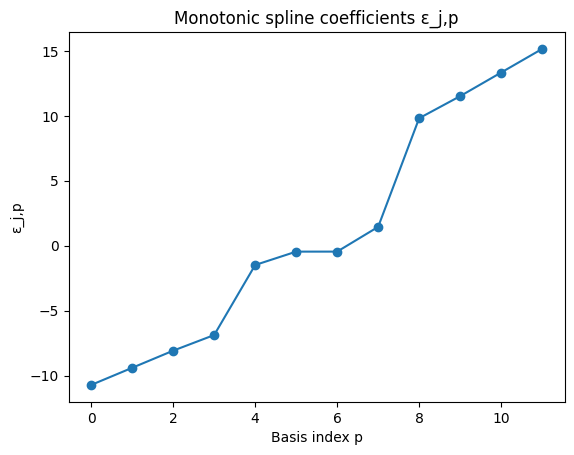

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.8886, -8.0066, -6.1235, -4.2408, -2.3616, -1.0884,  0.0146,  1.4965,
         4.4978,  7.2178,  9.0360, 10.8542])


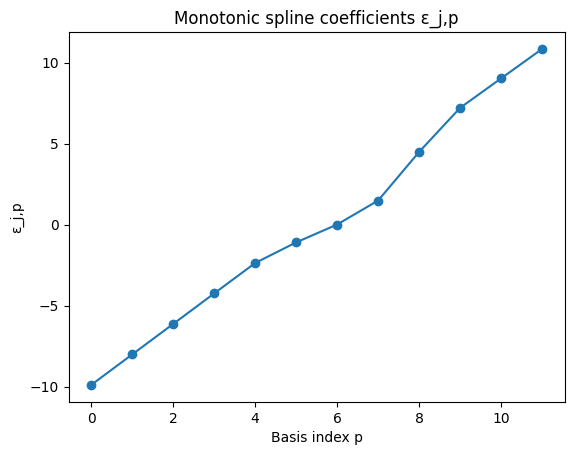

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.8251, -7.8890, -5.9529, -3.9760, -3.1212, -0.0432,  0.2975,  5.1517,
         7.2412,  9.0594, 10.8775, 12.6957])


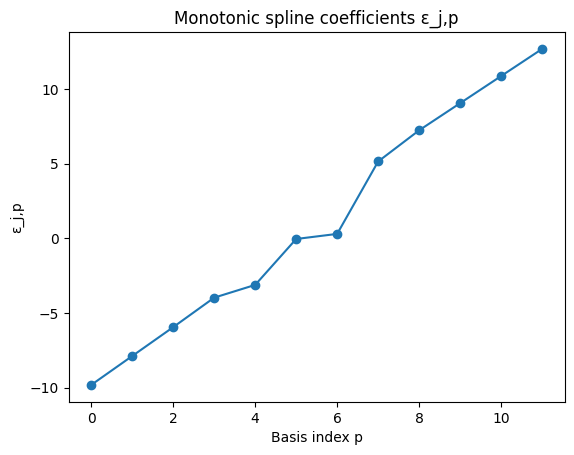

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9127, -8.0813, -6.2451, -4.4104, -2.5410, -0.5912,  0.7539,  3.5419,
         6.3307,  8.1489,  9.9671, 11.7853])


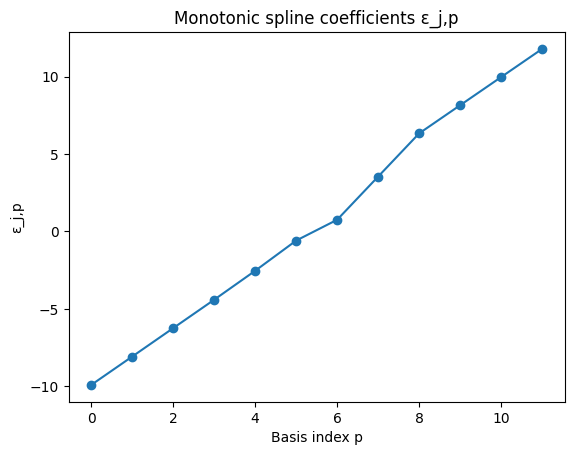

In [43]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

In [44]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [45]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.4413
KLD GTM      Train Data:  0.0799
KLD Gaussian Train Data:  -0.2811
KLD Copula   Train Data:  0.5543

KLD BGTM      Test  Data:  0.4323
KLD GTM      Test  Data:  0.0765
KLD Gaussian Test  Data:  -0.2982
KLD Copula   Test  Data:  0.5432


In [46]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

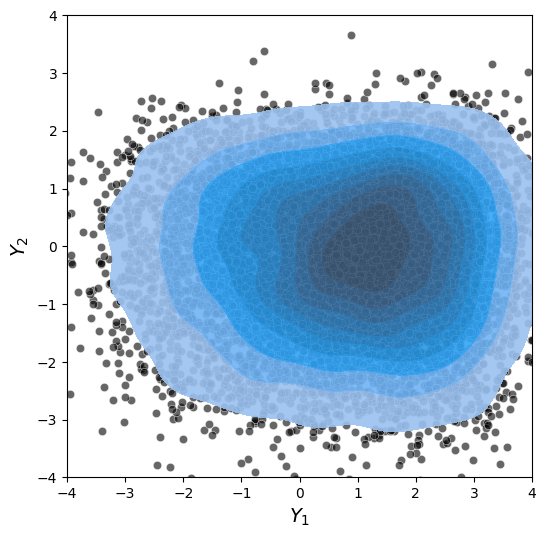

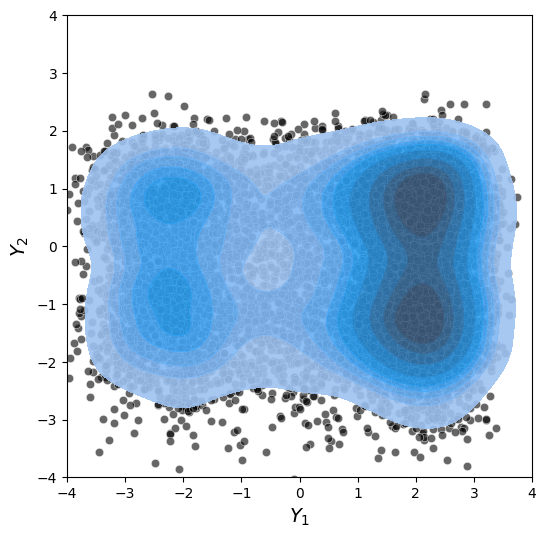

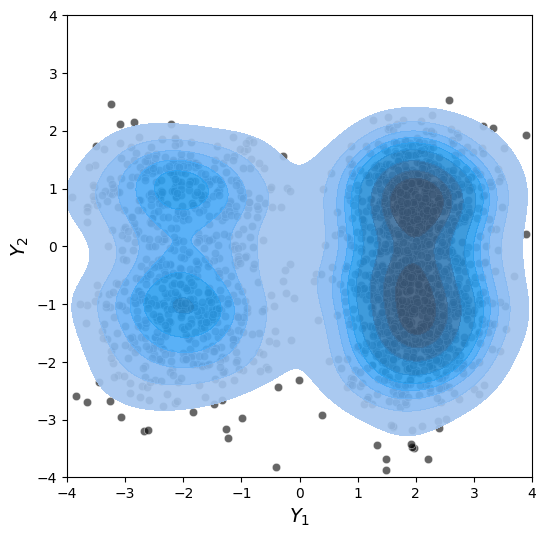

In [47]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])